# Time series forecasting: Comparing ARIMA, LSTM, GRU, Attention & KANs

## 1. Project Overview: Comparative Analysis of Time Series Models for Stock Forecasting

This notebook contains a personal project aimed at exploring, implementing, and evaluating a diverse set of time series forecasting models for the task of future prediction. The primary goal was to gain practical experience with various techniques, ranging from classical statistical methods to state-of-the-art deep learning architectures, and to compare their relative performance using standard financial data.

**Dataset:** The analysis utilizes historical data of Alphabet Inc.(GOOG) which can be found on Kaggle (<https://www.kaggle.com/datasets/varpit94/google-stock-data>). The data is available at a daily level. Currency is USD.

**Models Explored:**
* **Classical:** ARIMA
* **Recurrent Neural Networks (RNNs):** LSTM, GRU
* **Advanced RNNs:** LSTM, GRU with Attention Mechanism
* **Novel Architectures:** Kolmogorov-Arnold Networks (KANs)

**Key Findings:** Performance was evaluated using Mean Squared Error (MSE), with a notable result being that the GRU with Attention model demonstrated a **18% reduction in future stock returns prediction MSE** compared to the baseline ARIMA model. The LSTM with Attention and the basic GRU model also shows very good results with a **16% reduction in prediction MSE** compared to the baseline ARIMA model.

**Technology Stack:** Python, Pandas, NumPy, Scikit-learn, Statsmodels, Matplotlib/Seaborn, TensorFlow/Keras, PyTorch.

**Notebook Structure:** This notebook covers the end-to-end process, including library imports, data loading, exploratory data analysis (EDA), preprocessing (scaling, windowing), model definition and training, performance evaluation, and comparison of results.

## 2. Setup & Imports

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import time as time

from IPython.display import Markdown

import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/google-stock-data/GOOGL.csv


In [2]:
## downloading additional packages for ARIMA & KAN

!pip install -q pmdarima ## auto arima module
!pip install -q pykan  ## KAN module
#pip install -q lightning  ## Lightning AI module for torch

In [3]:
## Loading the required libraries

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

import pmdarima as pm
from kan import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD

from scipy import stats

#import lightning as L

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from torch.utils.data import TensorDataset, DataLoader

import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, TimeDistributed, Attention, Permute, Reshape, Multiply, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

## 3. Data Loading & Exploration (EDA)

In [4]:
df_goog = pd.read_csv('/kaggle/input/google-stock-data/GOOGL.csv')
print(f'shape of the data: {df_goog.shape}')
df_goog.head()

shape of the data: (4431, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659096
1,2004-08-20,50.555557,54.594597,50.300301,54.209209,54.209209,22834343
2,2004-08-23,55.430431,56.796799,54.579578,54.754753,54.754753,18256126
3,2004-08-24,55.675674,55.855858,51.836838,52.487488,52.487488,15247337
4,2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188602


#### Let's take a look at the data type of every columns and ensure they are in correct format for our analysis.

In [5]:
df_goog.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

#### The only modification we would need to do is to change the Date column to a pandas datetime object.

In [6]:
df_goog.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

#### The data do not contain any NaN values, hence we do not need to clean any further. Since the Adjusted Close is same as the Close value of the stock, we drop the column 'Adj Close' in the next. Also, we convert the Date column into a numpy datettime array.

In [7]:
df = df_goog.drop('Adj Close',axis=1)
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Open,High,Low,Close,Volume
0,2004-08-19,50.050049,52.082081,48.028027,50.220219,44659096
1,2004-08-20,50.555557,54.594597,50.300301,54.209209,22834343
2,2004-08-23,55.430431,56.796799,54.579578,54.754753,18256126
3,2004-08-24,55.675674,55.855858,51.836838,52.487488,15247337
4,2004-08-25,52.532532,54.054054,51.991993,53.053055,9188602


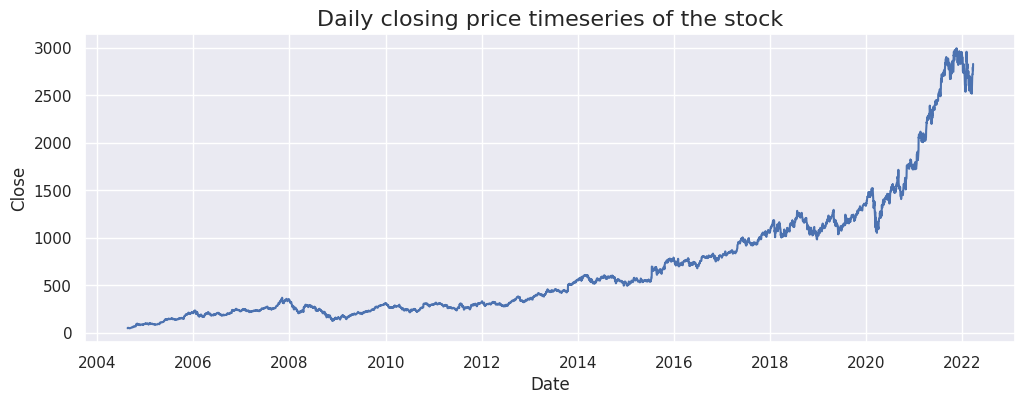

In [8]:
## Plotting the daily closing price of the stock with time

sns.set(context='notebook',style='darkgrid')

fig,ax = plt.subplots(1,1,figsize=(12,4))

sns.lineplot(data=df,x='Date',y='Close',ax=ax)

ax.set_title('Daily closing price timeseries of the stock',fontsize=16)

plt.show()

#### For the subsequent analysis, we create some additional columns to calculate the daily change, return and log return of the closing price of the stock. Additionally, we also add rolling averages. For rolling averages, we choose Exponential Moving Average (EMA) to avoid any loss of data.

In [9]:
df['Daily Change'] = df['Close'].diff()
df['Return'] = df['Close'] / df['Close'].shift(1)
df['Log Return'] = np.log(df['Return'])

df['EMA'] = df['Close'].ewm(span=20,adjust=True).mean()
df['EMA Return'] = df['EMA'] / df['EMA'].shift(1)

df.head()

,Date,Open,High,Low,Close,Volume,Daily Change,Return,Log Return,EMA,EMA Return
0,2004-08-19,50.050049,52.082081,48.028027,50.220219,44659096,NaN,NaN,NaN,50.220219,NaN
1,2004-08-20,50.555557,54.594597,50.300301,54.209209,22834343,3.988990,1.079430,0.076433,52.314439,1.041701
2,2004-08-23,55.430431,56.796799,54.579578,54.754753,18256126,0.545544,1.010064,0.010013,53.210508,1.017129
3,2004-08-24,55.675674,55.855858,51.836838,52.487488,15247337,-2.267265,0.958592,-0.042289,53.001783,0.996077
4,2004-08-25,52.532532,54.054054,51.991993,53.053055,9188602,0.565567,1.010775,0.010718,53.014185,1.000234


In [10]:
## Remove the NaN value in the first row.

df = df.iloc[1:,:].reset_index(drop=True)
df.head()

,Date,Open,High,Low,Close,Volume,Daily Change,Return,Log Return,EMA,EMA Return
0,2004-08-20,50.555557,54.594597,50.300301,54.209209,22834343,3.988990,1.079430,0.076433,52.314439,1.041701
1,2004-08-23,55.430431,56.796799,54.579578,54.754753,18256126,0.545544,1.010064,0.010013,53.210508,1.017129
2,2004-08-24,55.675674,55.855858,51.836838,52.487488,15247337,-2.267265,0.958592,-0.042289,53.001783,0.996077
3,2004-08-25,52.532532,54.054054,51.991993,53.053055,9188602,0.565567,1.010775,0.010718,53.014185,1.000234
4,2004-08-26,52.527527,54.029030,52.382381,54.009010,7094898,0.955955,1.018019,0.017858,53.224048,1.003959


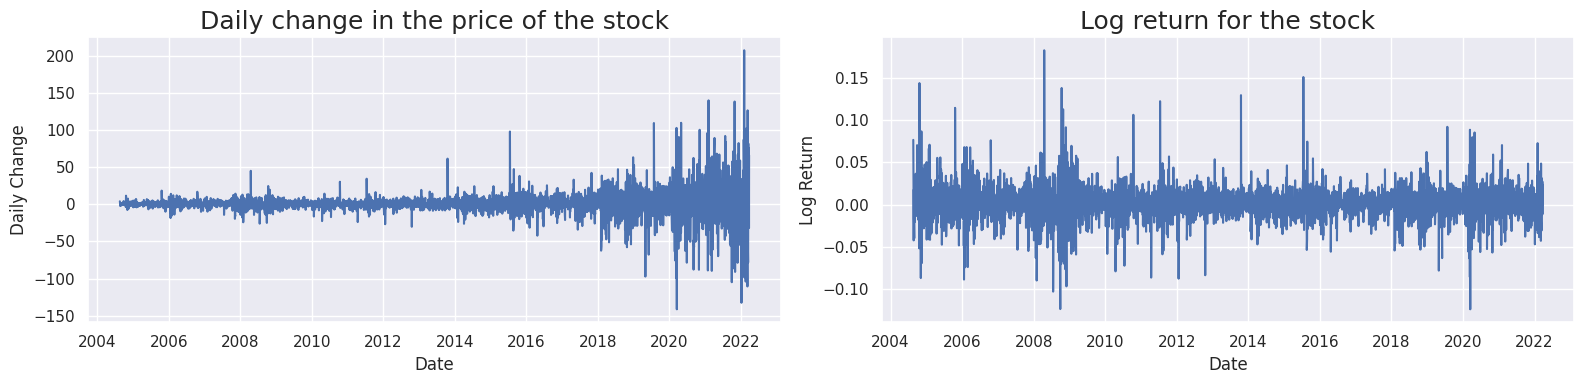

In [20]:
## Plotting the daily change and the log return with time

sns.set(context='notebook',style='darkgrid')

fig,ax = plt.subplots(1,2,figsize=(16,4))

sns.lineplot(data=df,x='Date',y='Daily Change',ax=ax[0])
sns.lineplot(data=df,x='Date',y='Log Return',ax=ax[1])

ax[0].set_title('Daily change in the price of the stock',fontsize=18)
ax[1].set_title('Log return for the stock',fontsize=18)

plt.tight_layout()
plt.show()

#### From the plot of the log return above, we can identify one highly volatile period, which is around $2008$, due to the world economic crisis. For the analysis in this notebook, we only consider data post 2010, as the effect of the crisis was also prevalent in $2009$. Additionally, the daily change of the closing price shows high volatility post 2020 and for the suitability for the ARIMA model, we restrict the data also to $2020$.

In [11]:
## Selecting data from a particular era

era_mask = (df['Date'].dt.year >= 2010) & (df['Date'].dt.year < 2020)

df_era = df[era_mask].reset_index(drop=True)

print(f'shape of the data is: {df_era.shape}')
df_era.head()

shape of the data is: (2516, 11)


,Date,Open,High,Low,Close,Volume,Daily Change,Return,Log Return,EMA,EMA Return
0,2010-01-04,313.788788,315.070068,312.432434,313.688690,3908488,3.388397,1.010920,0.010861,302.787176,1.003804
1,2010-01-05,313.903900,314.234222,311.081085,312.307312,6003391,-1.381378,0.995596,-0.004413,303.693855,1.002994
2,2010-01-06,313.243256,313.243256,303.483490,304.434448,7949443,-7.872864,0.974791,-0.025532,303.764388,1.000232
3,2010-01-07,305.005005,305.305298,296.621613,297.347351,12815771,-7.087097,0.976720,-0.023555,303.153242,0.997988
4,2010-01-08,296.296295,301.926941,294.849854,301.311310,9439151,3.963959,1.013331,0.013243,302.977820,0.999421


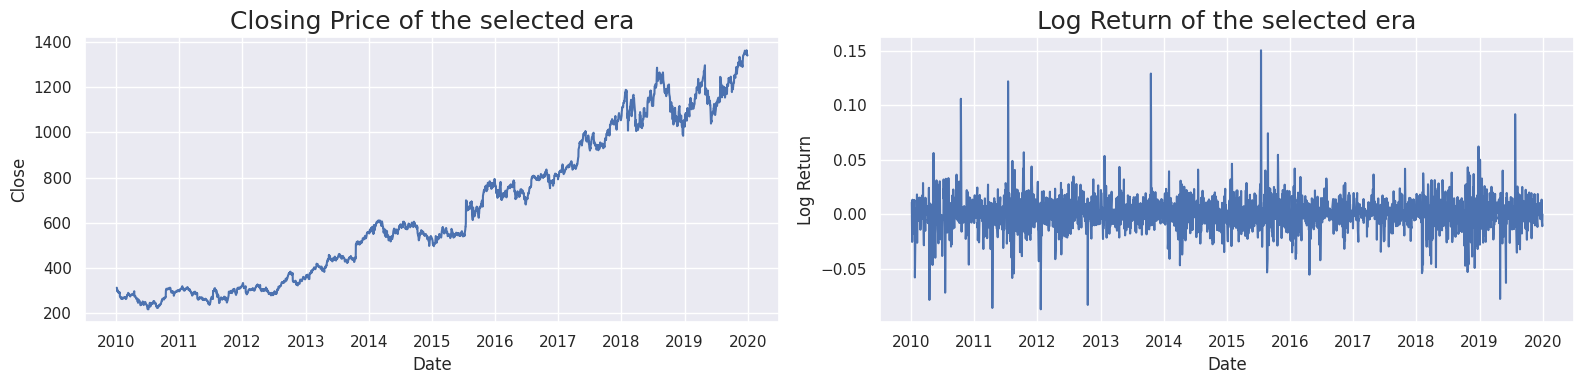

In [23]:
## Plotting the daily closing price and log return of the stock in the selected time period

sns.set(context='notebook',style='darkgrid')

fig,(ax0,ax1) = plt.subplots(1,2,figsize=(16,4))

sns.lineplot(data=df_era,x='Date',y='Close',ax=ax0)
sns.lineplot(data=df_era,x='Date',y='Log Return',ax=ax1)

ax0.set_title('Closing Price of the selected era',fontsize=18)
ax1.set_title('Log Return of the selected era',fontsize=18)

plt.tight_layout()
plt.show()

#### For the comparison of the prediction from different models, we define a mean-square loss below. One can also use other losses.

In [12]:
def mse_loss(y_true,y_pred):
    return np.sqrt(np.mean(np.square(y_true - y_pred)))

df_copy = df_era.copy() ## A copy of the actual data is used, so that the original remains unharmed

## 4. Data Preprocessing

#### To identify the optimum train-test split ratio, we run a loop over a set of choices for the train-test split ratios. For each of them, we fit an ARIMA model on the training set using the auto arima method from the pmdarima module which we have imported as pm. Then we measure the mean-square loss for the corresponding test sets to compare and find out the optimum train-test ratio.

In [25]:
split_ratios = np.arange(0.6,0.91,0.05)

loss_dict = {}

for split_ratio in split_ratios:
    split_indx = int(df_copy.shape[0]*split_ratio)

    df_train = df_copy['Close'].iloc[:split_indx]
    df_test = df_copy['Close'].iloc[split_indx:]

    auto_arima = pm.auto_arima(df_train,stepwise=False,seasonal=False)
    forecast_auto = auto_arima.predict(n_periods=len(df_test))

    mse_loss_val = mse_loss(df_test,forecast_auto)
    loss_dict[split_ratio] = mse_loss_val

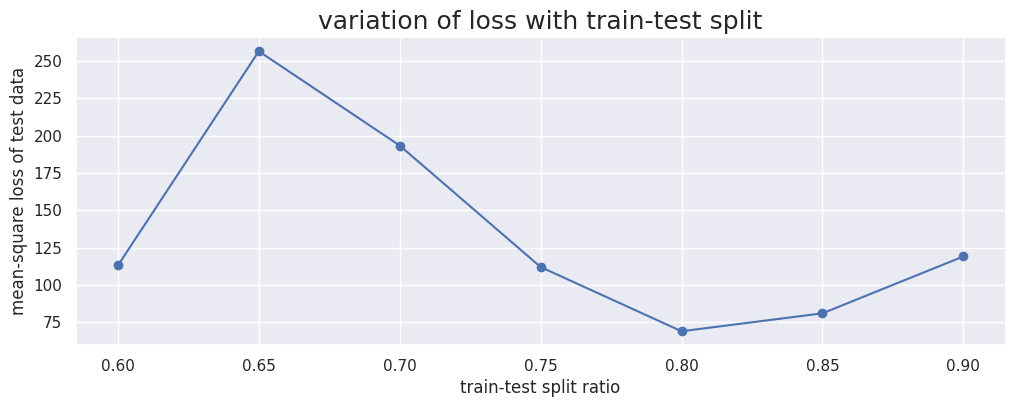

In [27]:
## Plotting the loss with corresponding train-test split ratio

fig,ax = plt.subplots(1,1,figsize=(12,4))

ax.plot(split_ratios,list(loss_dict.values()),'-o',markersize=6)

ax.set(xlabel='train-test split ratio',ylabel='mean-square loss of test data')
ax.set_title('variation of loss with train-test split',fontsize=18)

plt.show()

#### Since, the test loss is minimum at $0.8$, we identify $0.8$ as the optimum train-test ratio for our subsequent analysis.

In [13]:
optimum_split_ratio = 0.8
split_index = int(df_copy.shape[0]*optimum_split_ratio)

## 5. Model Implementation & Training

#### With the ARIMA, we attempt to model the closing price of the stock. Hence we need look at the closing price time series and its first difference, which is the daily change of the closing price of the stock. This determines the order of the difference needed in the ARIMA to reach a stationary series.

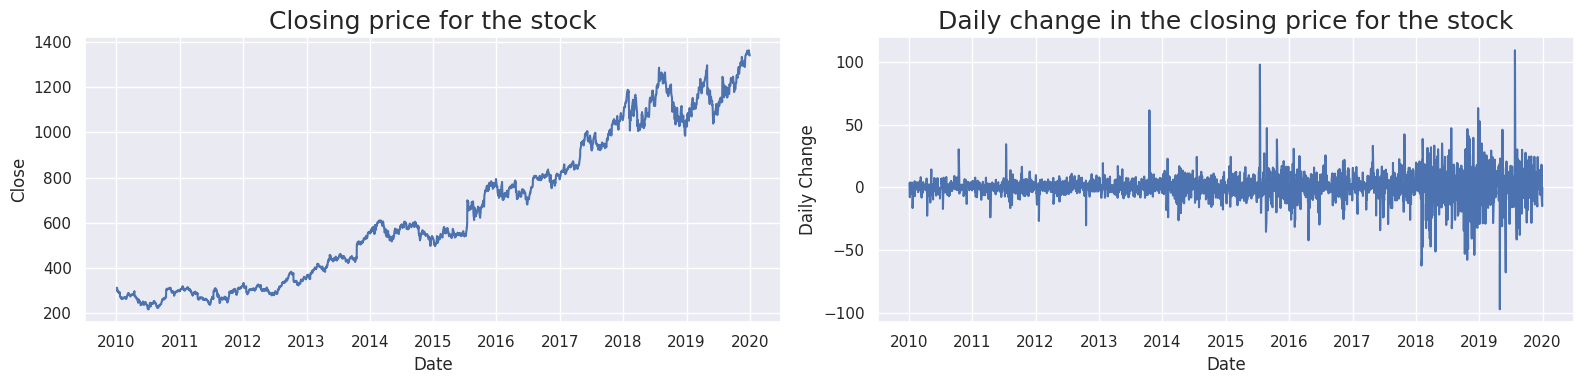

In [45]:
## Closing price and its daily change with time

fig,ax = plt.subplots(1,2,figsize=(16,4))

sns.lineplot(data=df_copy,x='Date',y='Close',ax=ax[0])
sns.lineplot(data=df_copy,x='Date',y='Daily Change',ax=ax[1])

ax[0].set_title('Closing price for the stock',fontsize=18)
ax[1].set_title('Daily change in the closing price for the stock',fontsize=18)

plt.tight_layout()
plt.show()

#### The first difference of the closing price appears stationary and without any bias. Hence a suitable ARIMA model should be of the form $(m,1,n)$. We find the $m, n$ from the Auto-Correlation Function (ACF) and Partial Auto-Correlation Function (PACF) plots.

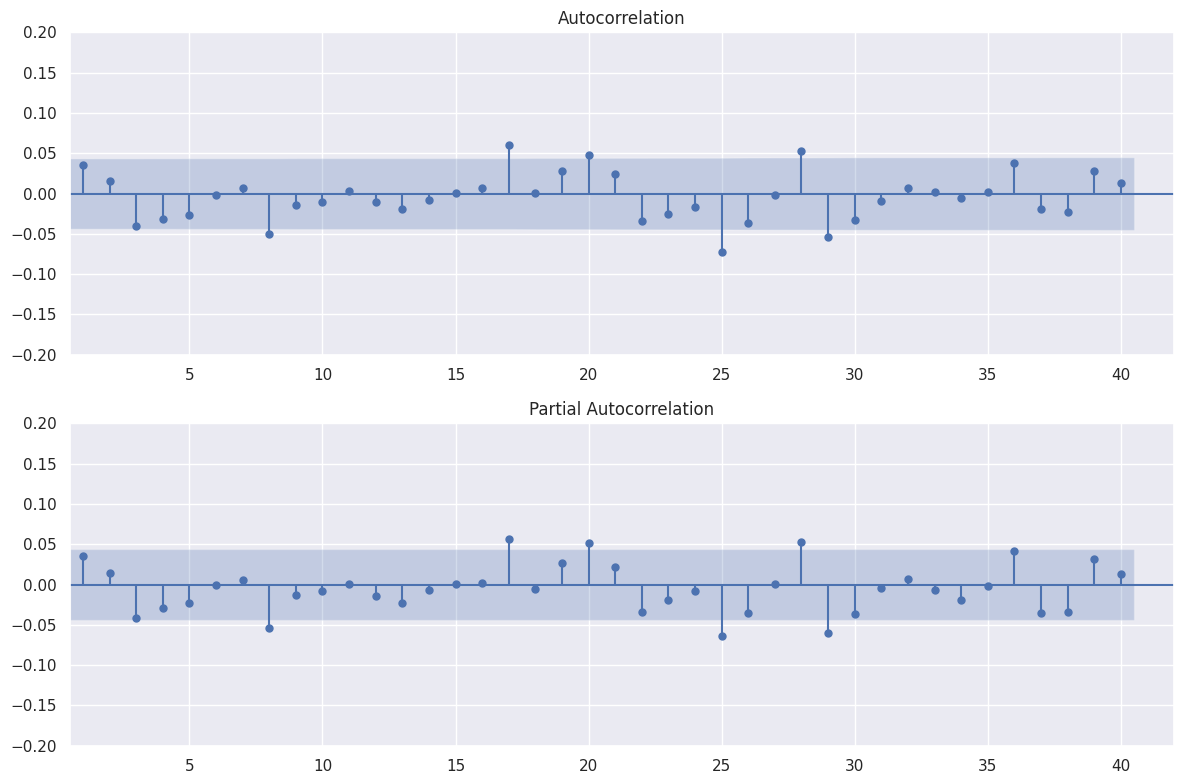

In [37]:
feature = 'Daily Change'

fig = plt.figure(figsize=(12, 8))
ax0 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_copy[feature].iloc[1:split_index], lags=40, ax=ax0)
ax1 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_copy[feature].iloc[1:split_index], lags=40, ax=ax1)

ax0.set(xlim=[0.5,42],ylim=[-0.2,0.2])
ax1.set(xlim=[0.5,42],ylim=[-0.2,0.2])

plt.tight_layout()
plt.show()

#### For this particular timeseries, we can not see any clear order from the correlation. Both the ACF and PACF follows similar pattern and falls below the significance band. We do not expect a good result from the ARIMA. However, to make an estimate we can note that the PACF hits zero at the 6th node and hence we try to fit an ARIMA(5,1,0) as an initial guess and compare it with the results of autoarima module.

### 5.1 ARIMA model on daily closing price

In [14]:
## Fitting the ARIMA model

feature = 'Close'

train_arima = df_copy[feature].iloc[:split_index]
test_arima = df_copy[feature].iloc[split_index:]

model_arima = ARIMA(train_arima,order=(5,1,0)).fit()
model_auto_arima = pm.auto_arima(train_arima,stepwise=False,seasonal=False)

## Predictions for the future (the test set) using the past data (the training set)

predictions_arima = model_arima.forecast(steps=len(test_arima))
predictions_auto_arima = model_auto_arima.predict(n_periods=len(test_arima))

In [15]:
model_auto_arima

ARIMA(order=(1, 1, 3), scoring_args={}, suppress_warnings=True)

#### The autoarima module fits an ARIMA(1,1,3), compared to our ARIMA(5,1,0) model.

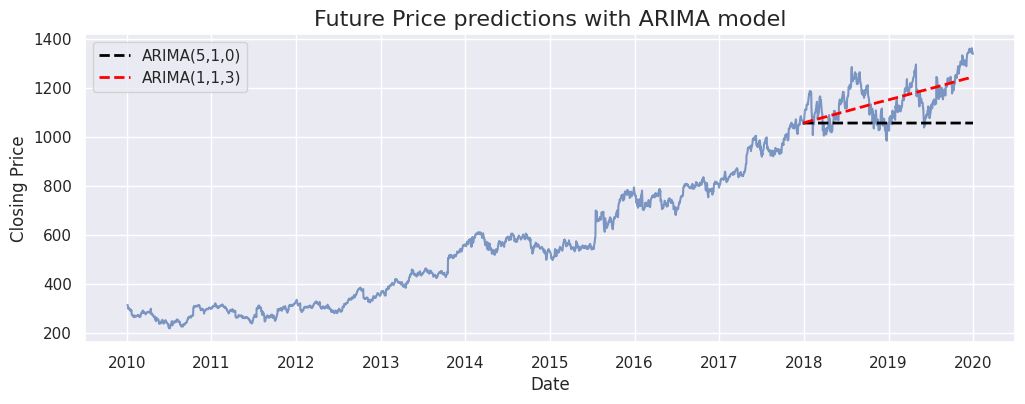

In [17]:
## Comparing the predictions with observed data

plt.figure(figsize=(12,4))

plt.plot(df_copy['Date'],df_copy[feature],alpha=0.7)
plt.plot(df_copy['Date'].iloc[split_index:], predictions_arima,ls='dashed',lw=2,color='black',label='ARIMA(5,1,0)')
plt.plot(df_copy['Date'].iloc[split_index:], predictions_auto_arima,ls='dashed',lw=2,color='red',label='ARIMA(1,1,3)')

plt.gca().set(xlabel='Date',ylabel='Closing Price')
plt.gca().set_title('Future Price predictions with ARIMA model',fontsize=16)
plt.legend()

plt.show()

#### In terms of performance, the ARIMA(1,1,3) does a better job than the ARIMA(5,1,0) and captures the upward trend of the price. However, it is unable to predict the short term ups and downs in the timeseries. We quantify the performances by computing the relative mean-square error.

In [18]:
loss_ARIMA = mse_loss(test_arima,predictions_arima)/test_arima.mean()
loss_auto_ARIMA = mse_loss(test_arima,predictions_auto_arima)/test_arima.mean()

print(f'The relative error in the ARIMA(5,1,0) model : {loss_ARIMA}')
print(f'The relative error in the ARIMA(1,1,3) model : {loss_auto_ARIMA}')

The relative error in the ARIMA(5,1,0) model : 0.11180964188330172
The relative error in the ARIMA(1,1,3) model : 0.059669718598843104


#### The ARIMA do not seem to capture the short-term fluctuations well, and from our previous analysis, we had expected the model to perform not so well. For a better results, we find that rather than the actual price or the moving averages, the time series of the daily returns (computed from the EMA) is most suitable for predictions. Thus, for ARIMA and subsequent machine learning models we will be using the daily returns, rather than the actual daily price.

### 5.2 ARIMA on daily return of the EMA of closing price

#### As before, We look at the EMA returns timeseries and its first difference.

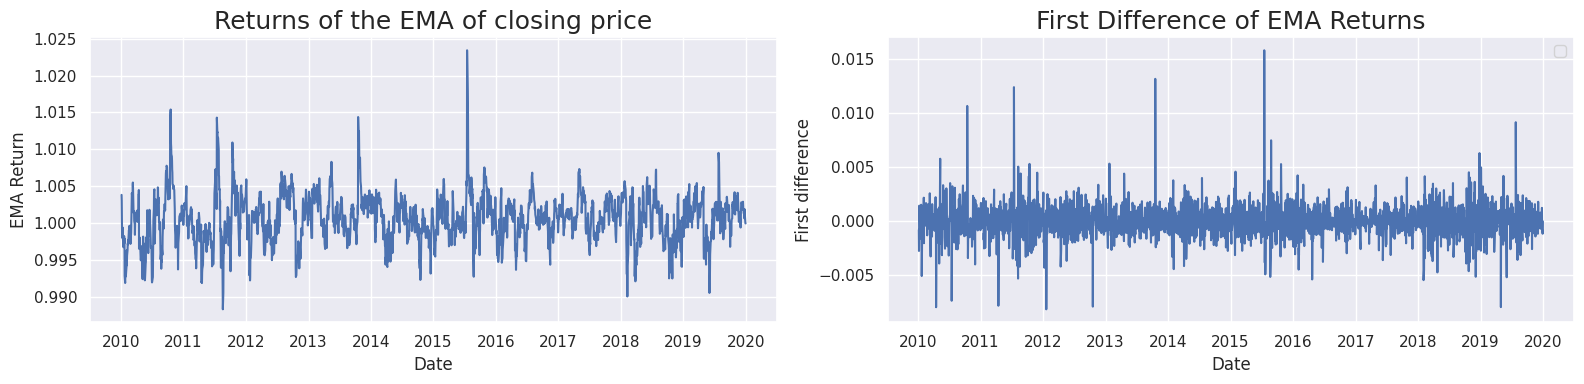

In [21]:
df_copy['EMA Returns first diff'] = df_copy['EMA Return'].diff()

fig,(ax0,ax1) = plt.subplots(1,2,figsize=(16,4))

sns.lineplot(data=df_copy,x='Date',y='EMA Return',ax=ax0)
sns.lineplot(data=df_copy,x='Date',y=df_copy['EMA Returns first diff'],ax=ax1)

ax0.set_title('Returns of the EMA of closing price',fontsize=18)
ax1.set(ylabel='First difference')
ax1.set_title('First Difference of EMA Returns',fontsize=18)

plt.legend()

plt.tight_layout()
plt.show()

#### The EMA return and its first difference, both these fluctuate about a constant mean value. Hence, we can work with the EMA returns itself and fit an ARIMA(m,0,n) type model on the EMA return time series.

#### Now we look at the ACF and PACF for this time series.

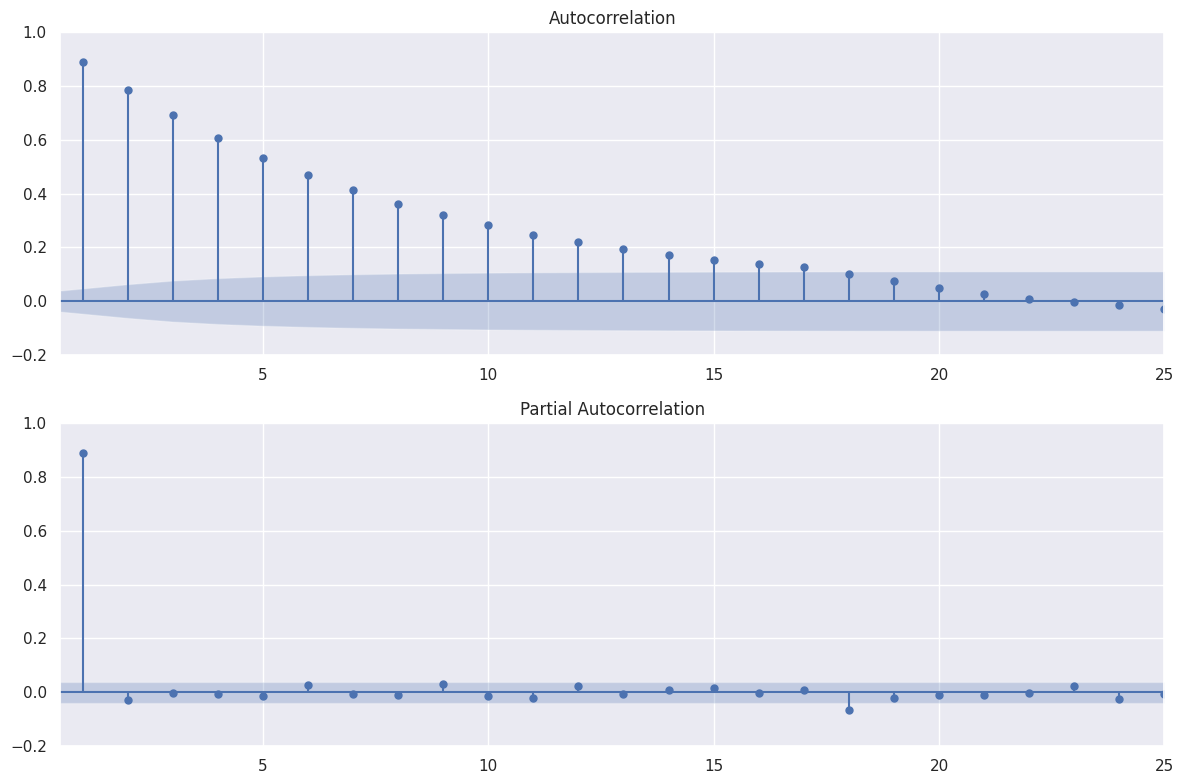

In [22]:
feature = 'EMA Return'

fig = plt.figure(figsize=(12, 8))
ax0 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_copy[feature].iloc[:], lags=25, ax=ax0)
ax1 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_copy[feature].iloc[:], lags=25, ax=ax1)

ax0.set(xlim=[0.5,25],ylim=[-0.2,1])
ax1.set(xlim=[0.5,25],ylim=[-0.2,1])

plt.tight_layout()
plt.show()

#### This time we can see that the ACF goes to zero, whereas the PACF has last significant spike at the 9th node. Thus we shall proceed with a AR(9) model, i.e. ARIMA(9,0,0) model.

In [24]:
feature = 'EMA Return'

train_arima = df_copy[feature].iloc[:split_index]
test_arima = df_copy[feature].iloc[split_index:]

model_arima_return = ARIMA(train_arima,order=(9,0,0)).fit()
model_auto_arima_return = pm.auto_arima(train_arima,stepwise=False,seasonal=False)

## Future predictions using past data

predictions_arima_return = model_arima_return.forecast(steps=len(test_arima))
predictions_auto_arima_return = model_auto_arima_return.predict(n_periods=len(test_arima))

In [25]:
model_auto_arima_return

ARIMA(order=(2, 0, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

#### The autoarima module fits an ARIMA(2,0,2) model, compared to our ARIMA(9,0,0) model.

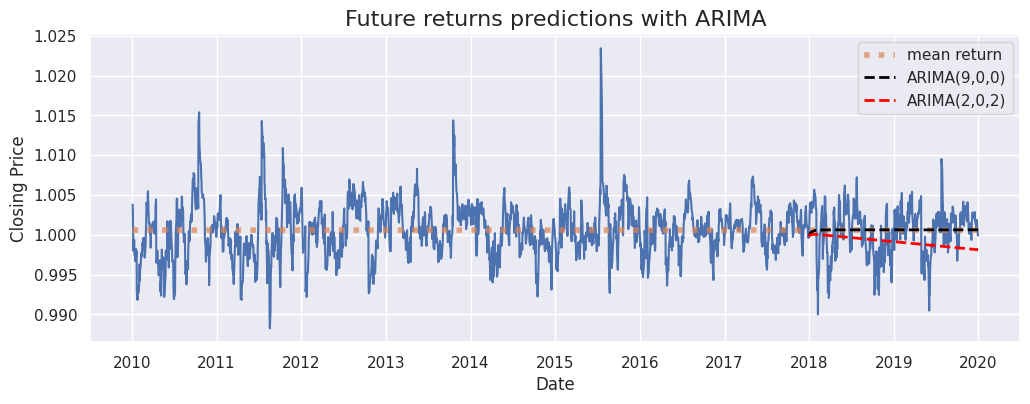

In [27]:
## Future predictions compared with observed data

plt.figure(figsize=(12,4))
ax = plt.gca()

ax.plot(df_copy['Date'],df_copy[feature])
ax.plot(df_copy['Date'],np.ones(df_copy.shape[0])*df_copy[feature].mean(), ls='dotted',lw=4,alpha=0.7, label='mean return')
ax.plot(df_copy['Date'].iloc[split_index:], predictions_arima_return,ls='dashed',lw=2,color='black',label='ARIMA(9,0,0)')
ax.plot(df_copy['Date'].iloc[split_index:], predictions_auto_arima_return,ls='dashed',lw=2,color='red',label='ARIMA(2,0,2)')

ax.set(xlabel='Date',ylabel='Closing Price')
ax.set_title('Future returns predictions with ARIMA',fontsize=16)
plt.legend()

plt.show()

#### The ARIMA models predict a downward trend, although both of them were unable to capture the daily fluctuations in the time series. Notably, the ARIMA(9,0,0) predictions converge to the mean return of this time period.

In [28]:
loss_ARIMA_return = mse_loss(test_arima,predictions_arima_return)/test_arima.mean()
loss_auto_ARIMA_return = mse_loss(test_arima,predictions_auto_arima_return)/test_arima.mean()

print(f'The relative error in the ARIMA(6,0,0) model : {loss_ARIMA_return}')
print(f'The relative error in the Auto ARIMA model : {loss_auto_ARIMA_return}')

The relative error in the ARIMA(6,0,0) model : 0.002962445841860188
The relative error in the Auto ARIMA model : 0.003334250673016972


#### Let's compare the losses from the ARIMAs on both these time series

In [29]:
loss_dict = {}

loss_dict['Our ARIMA'] = pd.Series([loss_ARIMA,loss_ARIMA_return],index=['Price','Returns'])
loss_dict['Auto ARIMA'] = pd.Series([loss_auto_ARIMA,loss_auto_ARIMA_return],index=['Price','Returns'])

pd.DataFrame(loss_dict)

,Our ARIMA,Auto ARIMA
Price,0.111810,0.059670
Returns,0.002962,0.003334


#### As expected, the ARIMA models do a better job on the returns. The loss of the autoarima module is slightly higher than our estimated ARIMA(9,0,0) model for the returns. We observed that the autoarima predicts a much sharper downward trend, whereas the ARIMA(9,0,0) predictions stays close to the mean and eventually converge to it, it has a smaller loss. In the next sections, we work with neural networks, starting with Long Short Term Memory (LSTM) network, which is used heavily for time series prediction.

### 5.3 LSTM Neural Network

#### As explained before, we shall use our model on the returns, rather than the prices. We consider both the timeserieses of daily return and the EMA returns of the stock and find that LSTM works much better on the EMA returns.

#### Data preprocessing for LSTM

#### We begin with the timeseries of daily return. To create multiple training data, we use the sliding window technique. Based on initial experiments, the window size is chosen as 20, which is the typical number of trading days in a month.

In [30]:
## Parameters

nrows = df_copy.shape[0]
horizon = 1 ## How many future steps to predict
train_split_ratio = 0.8 ## Same as the optimum found for ARIMA

## Hyperparameters

WINDOW_SIZE = 20
NUM_LAYERS = 32 ## number of parallel LSTM layers.
DROPOUT = 0.2
N_FEATURES = 1 ## Since we are using only 1 feature.

## scaling the data to the range [0,1] using MinMaxScaler

feature = 'Return'

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_copy[feature].values.reshape(-1,1)).flatten()

split_index = int(nrows * train_split_ratio)
df_train_scaled = df_scaled[:split_index]
df_val_scaled = df_scaled[split_index:]

print(f"Train shape: {df_train_scaled.shape}")
print(f"Validation shape: {df_val_scaled.shape}")

Train shape: (2012,)
Validation shape: (504,)


#### We use a single time series for the LSTM and other Neural networks. One can also use multiple time series, hence increasing the number of features (N_FEATURES). However, we found that using only the EMA returns time series produces the best outcome.

In [31]:
def create_sequences_for_lstm(data, window_size, horizon):
    """
    Creates sequences and targets from time series data.
    Input data shape: (n_series, n_steps)
    Output X shape: (n_samples, window_size, 1) ## LSTM needs 3D input
    Output y shape: (n_samples, window_size, 1) ## For timedistributed
    """
    X, y = [], []
    n_steps = data.shape[0]
    for j in range(n_steps - window_size):
        window = data[j:(j + window_size)]
        target = data[(j + horizon):(j + window_size + horizon)]
        X.append(window)
        y.append(target)

    # Reshaping X to be 3D for LSTM: (n_samples, window_size, n_features=1)
    return np.array(X).reshape(-1, window_size, 1), np.array(y).reshape(-1,window_size,1)


## Creating training and validation sets

X_train, y_train = create_sequences_for_lstm(df_train_scaled, WINDOW_SIZE, horizon)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

X_val, y_val = create_sequences_for_lstm(df_val_scaled, WINDOW_SIZE, horizon)
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: (1992, 20, 1), y_train shape: (1992, 20, 1)
X_val shape: (484, 20, 1), y_val shape: (484, 20, 1)


#### The LSTM model architecture

In [32]:
inputs = Input(shape=(WINDOW_SIZE, N_FEATURES),name='time_series_input')

## First LSTM layer
x = LSTM(units=NUM_LAYERS,return_sequences=True,name='LSTM_layer')(inputs)

# Dropout Layer
x = Dropout(DROPOUT,name='Dropout_layer')(x)

# Batch Normalization for stabilty
x = BatchNormalization(name='batch_norm')(x)

## Additional LSTM layer (if needed)
x = LSTM(units=NUM_LAYERS,return_sequences=True,name='LSTM_layer2')(x)

# Output Layer (Dense)
# units = HORIZON
# Sigmoid activation as data is in the range [0,1]
outputs = TimeDistributed(Dense(units=horizon, activation='sigmoid'),name='output_layer')(x)

# Creating the Model instance
LSTMmodel = Model(inputs=inputs, outputs=outputs, name='lstm_forecaster')

# --- Compiling the Model ---

# learning schedule for the optimizer
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

# Adam is used as the optimizer
opt = keras.optimizers.Adam(learning_rate=lr_schedule)

LSTMmodel.compile(optimizer=opt, loss='mse', metrics=[keras.metrics.MeanAbsoluteError()])

LSTMmodel.summary()

Model: "lstm_forecaster"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_series_input (InputLayer)  │ (None, 20, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_layer (LSTM)               │ (None, 20, 32)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_layer (Dropout)         │ (None, 20, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm (BatchNormalization) │ (None, 20, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_layer2 (LSTM)              │ (None, 20, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (TimeDistributed)  │ (None, 20, 1)          │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,833 (50.13 KB)

 Trainable params: 12,769 (49.88 KB)

 Non-trainable params: 64 (256.00 B)

In [102]:
## Training the model

start = time.time()

BATCH_SIZE = 200

early_stopping = EarlyStopping(monitor='val_loss', # Monitor validation loss
                               patience=10,        # Stop after 10 epochs with no improvement
                               restore_best_weights=True)

history = LSTMmodel.fit(X_train, y_train,
                    epochs=100,  # 100 epochs was enough for our case
                    batch_size=BATCH_SIZE,
                    validation_data=(X_val, y_val),
                    #callbacks=[early_stopping], # Add early stopping callback
                    shuffle=True, # Shuffle training windows each epoch
                    verbose=0
                    )

end = time.time()

print(f"Training finished. Time elapsed: {(end-start)} seconds.")

Training finished. Time elapsed: 39.09706401824951 seconds.


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


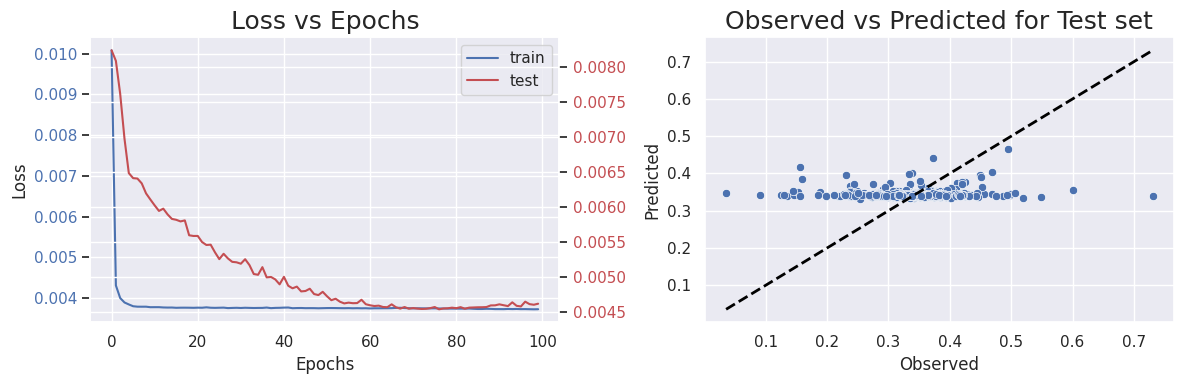

In [103]:
## Make predictions to validate
y_pred = LSTMmodel.predict(X_val)

fig,(ax0,ax1) = plt.subplots(1,2,figsize=(12,4))
ax2 = ax0.twinx()

ln1 = sns.lineplot(x=history.epoch,y=history.history['loss'],color='b',ax=ax0)
ln2 = sns.lineplot(x=history.epoch,y=history.history['val_loss'],color='r',ax=ax2)

sns.scatterplot(x=y_val[:,-1,0],y=y_pred[:,-1,0],ax=ax1)
sns.lineplot(x=y_val[:,-1,0],y=y_val[:,-1,0],ls='dashed',lw=2,color='black',ax=ax1)
ax1.set(xlabel='Observed',ylabel='Predicted')
ax1.set_title('Observed vs Predicted for Test set',fontsize=18)

lns = ln1.lines+ln2.lines
labs = ['train', 'test']
ax0.legend(lns, labs, loc=0)
ax0.tick_params(axis='y', labelcolor='b')
ax2.tick_params(axis='y', labelcolor='r')

ax0.set_title('Loss vs Epochs',fontsize=18)
ax0.set(xlabel='Epochs',ylabel='Loss')

plt.tight_layout()
plt.show()

#### As we can see, although the model reached a plateau in terms of both training and test losses, it did not a good job in terms of predictions. The bias in the model is too high and it predicts similar values for all inputs. We tried increasing the number of parameters in the model, but that did not resolve the issue. Hence, we now work with the time series of daily return of the EMA of the stock price.

In [33]:
## scaling using MinMaxScaler

feature = 'EMA Return'

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_copy[feature].values.reshape(-1,1)).flatten()

split_index = int(nrows * train_split_ratio)
df_train_scaled = df_scaled[:split_index]
df_val_scaled = df_scaled[split_index:]

print(f"Train shape: {df_train_scaled.shape}")
print(f"Validation shape: {df_val_scaled.shape}")

## Creating training and validation sets

X_train, y_train = create_sequences_for_lstm(df_train_scaled, WINDOW_SIZE, horizon)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

X_val, y_val = create_sequences_for_lstm(df_val_scaled, WINDOW_SIZE, horizon)
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

Train shape: (2012,)
Validation shape: (504,)
X_train shape: (1992, 20, 1), y_train shape: (1992, 20, 1)
X_val shape: (484, 20, 1), y_val shape: (484, 20, 1)


In [34]:
## Using the same LSTM model and training on the training set

LSTMmodel.compile(optimizer=opt, loss='mse', metrics=[keras.metrics.MeanAbsoluteError()])

start = time.time()

BATCH_SIZE = 200

early_stopping = EarlyStopping(monitor='val_loss', # Monitor validation loss
                               patience=10,        # Stop after 10 epochs with no improvement
                               restore_best_weights=True)

history = LSTMmodel.fit(X_train, y_train,
                    epochs=100,
                    batch_size=BATCH_SIZE,
                    validation_data=(X_val, y_val),
                    #callbacks=[early_stopping], # Early stopping callback
                    shuffle=True, # Shuffle training windows each epoch
                    verbose=0
                    )

end = time.time()

print(f"Training finished. Time elapsed: {(end-start)} seconds.")

Training finished. Time elapsed: 38.33265256881714 seconds.


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


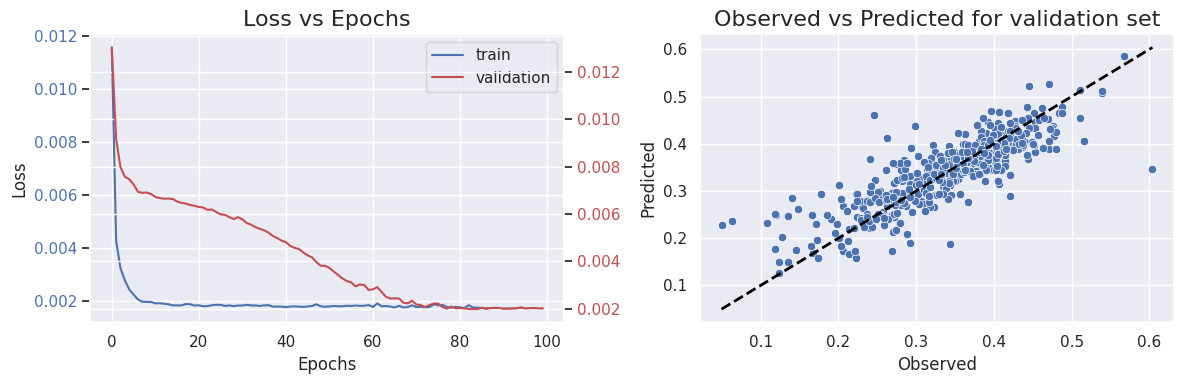

In [35]:
## Making predictions to validate
y_pred_EMA = LSTMmodel.predict(X_val)


fig,(ax0,ax1) = plt.subplots(1,2,figsize=(12,4))
ax2 = ax0.twinx()

ln1 = sns.lineplot(x=history.epoch,y=history.history['loss'],color='b',ax=ax0)
ln2 = sns.lineplot(x=history.epoch,y=history.history['val_loss'],color='r',ax=ax2)

sns.scatterplot(x=y_val[:,-1,0],y=y_pred_EMA[:,-1,0],ax=ax1)
sns.lineplot(x=y_val[:,-1,0],y=y_val[:,-1,0],ls='dashed',lw=2,color='black',ax=ax1)
ax1.set(xlabel='Observed',ylabel='Predicted')
ax1.set_title('Observed vs Predicted for validation set',fontsize=16)

lns = ln1.lines+ln2.lines
labs = ['train', 'validation']
ax0.legend(lns, labs, loc=0)
ax0.tick_params(axis='y', labelcolor='b')
ax2.tick_params(axis='y', labelcolor='r')

ax0.set_title('Loss vs Epochs',fontsize=16)
ax0.set(xlabel='Epochs',ylabel='Loss')

plt.tight_layout()
plt.show()

#### With the same model, working with the EMA returns rather than the actual returns, we get a much improved performance in terms of predictions on the validation set.

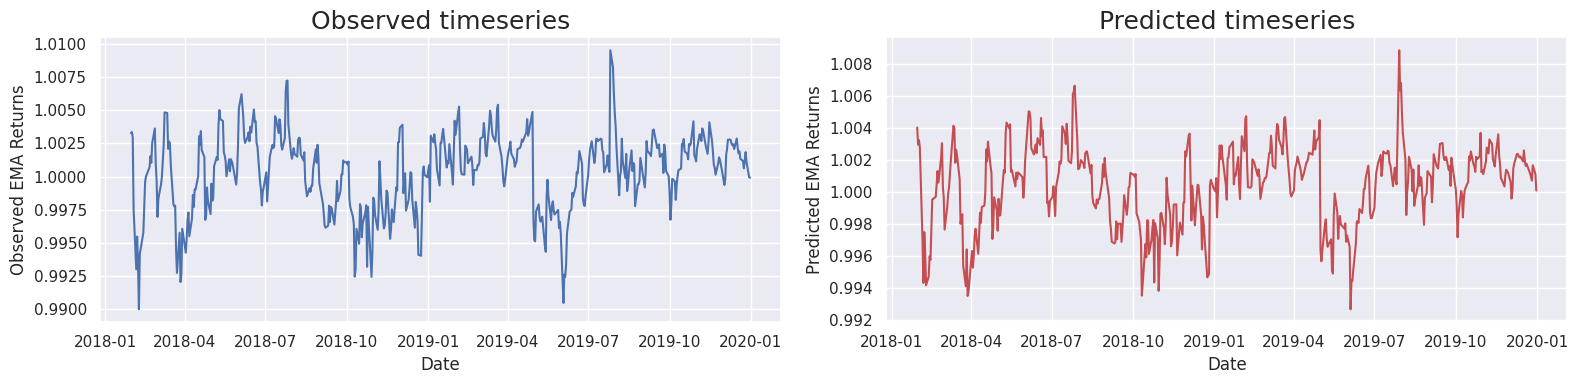

In [36]:
## Scale back the predictions
y_pred_actual_EMA = scaler.inverse_transform(y_pred_EMA[:,-1,0].reshape(-1,1)).flatten() ## transform back the timeseries

horizon_ahead = len(y_pred_actual_EMA)

fig,ax = plt.subplots(1,2,figsize=(16,4))

sns.lineplot(x=df_copy['Date'].iloc[-horizon_ahead:],y=df_copy['EMA Return'].iloc[-horizon_ahead:],ax=ax[0],color='b')
sns.lineplot(x=df_copy['Date'].iloc[-horizon_ahead:],y=y_pred_actual_EMA,ax=ax[1],color='r')

ax[0].set(ylabel='Observed EMA Returns')
ax[0].set_title('Observed timeseries',fontsize=18)
ax[1].set(ylabel='Predicted EMA Returns')
ax[1].set_title('Predicted timeseries',fontsize=18)

plt.tight_layout()
plt.show()

#### As we can see, the LSTM does a good job in capturing even the short-time flutuations in the EMA returns timeseries.

#### To see its performance in making predicting future using historical data, we define a function. The algorithm is as follows. We pass a historical data of the length equal to the window size, i.e. 20 and predict one future value. We the append use this predictions as part of the historical data to predict the next value and so on.

In [37]:
## Function to return future prices from past data

def predict_future_prices(MODEL,past_data,num_days):
    predicted_prices = []
    current_batch = np.array(past_data.iloc[-WINDOW_SIZE:])
    scaler = MinMaxScaler()
    scaled_batch = scaler.fit_transform(current_batch.reshape(-1,1)).flatten()

    current_batch = scaled_batch.reshape(1, WINDOW_SIZE, 1)

    for i in range(num_days):
        # Get the prediction (next day)
        next_prediction = MODEL.predict(current_batch,verbose=0)
    
        # Reshape the prediction to fit the batch dimension
        next_prediction_reshaped = next_prediction[:,-1,0].reshape(1, 1, 1)
    
        # Append the prediction to the batch used for predicting
        current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)
    
        # Inverse transform the prediction to the original price scale
        predicted_prices.append(next_prediction[:,-1,0])

    predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1,1)).flatten()
    return predicted_prices

In [38]:
## To compare with the predictions we use the data from the original dataframe

df_comp = df[df['Date'] >= df_copy['Date'].iloc[-WINDOW_SIZE]]

#### Using the data from last 20 trading days (one month), we predict the returns for the next month, i.e. 20 future trading days.

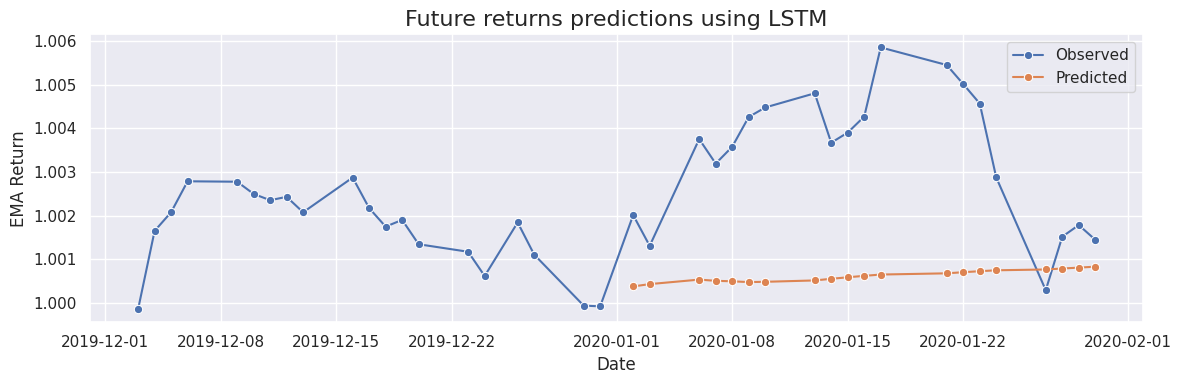

In [39]:
horizon_ahead = 20
predicted_prices = predict_future_prices(LSTMmodel,df_copy['EMA Return'],horizon_ahead)

fig,ax = plt.subplots(1,1,figsize=(12,4))

ln1 = sns.lineplot(x=df_comp['Date'].iloc[:WINDOW_SIZE+horizon_ahead],y=df_comp['EMA Return'].iloc[:WINDOW_SIZE+horizon_ahead],marker='o',ax=ax)
ln2 = sns.lineplot(x=df_comp['Date'].iloc[WINDOW_SIZE:WINDOW_SIZE+horizon_ahead],y=predicted_prices,marker='o',ax=ax)

lns = ln1.lines+ln2.lines
labs = ['Observed', 'Predicted']
ax.legend(lns, labs, loc=0)
ax.set_title('Future returns predictions using LSTM',fontsize=16)

plt.tight_layout()
plt.show()

#### In case of predicting future unknown values, we can see it does not do as great a job as it did for the validation set. The predicted values show little fluctuation (compared to actual data) around a constant value, quite similar to ARIMA.

In [40]:
## We measure the relative error in the predctions

actual_data = df_comp['EMA Return'].iloc[WINDOW_SIZE:WINDOW_SIZE+horizon_ahead]

loss_LSTM = mse_loss(actual_data,predicted_prices)/actual_data.mean()
print(f'The error in the LSTM model : {loss_LSTM}')
print(f'The error in the ARIMA model : {loss_ARIMA_return}')

The error in the LSTM model : 0.003172198066813779
The error in the ARIMA model : 0.002962445841860188


#### As we expected, the elative error obtained using the LSTM and ARIMA on future predictions are very similar. For the validation set though, where the ARIMA only captures the mean behaviour, the LSTM captures the short-term fluctuations to a excellent degree.

### 5.4 LSTM with attention mechanism

#### The idea here is to improve the performance of predicting future prices of the LSTM model by introducing Attention mechanism. Attention can potentially capture underlying long and short-range dependencies better.

In [41]:
## scaling the data using MinMax Scaler

feature = 'EMA Return'

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_copy[feature].values.reshape(-1,1)).flatten()

split_index = int(nrows * train_split_ratio)
df_train_scaled = df_scaled[:split_index]
df_val_scaled = df_scaled[split_index:]

print(f"Train shape: {df_train_scaled.shape}")
print(f"Validation shape: {df_val_scaled.shape}")

## Creating training and validation sets

X_train, y_train = create_sequences_for_lstm(df_train_scaled, WINDOW_SIZE, horizon)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

X_val, y_val = create_sequences_for_lstm(df_val_scaled, WINDOW_SIZE, horizon)
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

Train shape: (2012,)
Validation shape: (504,)
X_train shape: (1992, 20, 1), y_train shape: (1992, 20, 1)
X_val shape: (484, 20, 1), y_val shape: (484, 20, 1)


In [42]:
# Model architecture


inputs = Input(shape=(WINDOW_SIZE,N_FEATURES),name='time_series_input')

## Creating query, key and value for the attention module using linear transformation 

q_input = TimeDistributed(Dense(units=horizon,name='query'))(inputs)
k_input = TimeDistributed(Dense(units=horizon,name='key'))(inputs)
v_input = TimeDistributed(Dense(units=horizon,name='value'))(inputs)

## Pass the query, key, value to the attention layer
x_attn = Attention(name='Attention_layer')([q_input,v_input,k_input])

## Pass the data with attention scores to the LSTM
x = LSTM(units=NUM_LAYERS,return_sequences=True,name='LSTM_layer')(x_attn)

## dropout layer to avoid overfitting
x = Dropout(DROPOUT,name='Dropout_layer')(x)

## batch normalization for stability
x = BatchNormalization(name='batch_norm')(x)

## Second LSTM layer
x = LSTM(units=NUM_LAYERS,return_sequences=True,name='LSTM_layer2')(x)

## Final Dense layer with sigmoid activation
outputs = TimeDistributed(Dense(units=horizon, activation='sigmoid'),name='output_layer')(x)

lstmAttnModel = Model(inputs=inputs, outputs=outputs, name='lstm_forecaster')

# --- Compiling the Model ---

# learning schedule for the optimizer
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

# Adam is used as the optimizer
opt = keras.optimizers.Adam(learning_rate=lr_schedule)

lstmAttnModel.compile(optimizer=opt, loss='mse', metrics=[keras.metrics.MeanAbsoluteError()])

lstmAttnModel.summary()

Model: "lstm_forecaster"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ time_series_input   │ (None, 20, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 20, 1)     │          2 │ time_series_inpu… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 20, 1)     │          2 │ time_series_inpu… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 20, 1)     │          2 │ time_series_inpu… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Attention_layer     │ (None, 20, 1)     │          0 │ time_distributed… │
│ (Attention)         │                   │            │ time_distributed… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM_layer (LSTM)   │ (None, 20, 32)    │      4,352 │ Attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_layer       │ (None, 20, 32)    │          0 │ LSTM_layer[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_norm          │ (None, 20, 32)    │        128 │ Dropout_layer[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM_layer2 (LSTM)  │ (None, 20, 32)    │      8,320 │ batch_norm[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 20, 1)     │         33 │ LSTM_layer2[0][0] │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,839 (50.15 KB)

 Trainable params: 12,775 (49.90 KB)

 Non-trainable params: 64 (256.00 B)

In [43]:
## training the model

start = time.time()

BATCH_SIZE = 200

early_stopping = EarlyStopping(monitor='val_loss', # Monitor validation loss
                               patience=10,        # Stop after 10 epochs with no improvement
                               restore_best_weights=True)

history = lstmAttnModel.fit(X_train, y_train,
                    epochs=300,
                    batch_size=BATCH_SIZE,
                    validation_split=0.2,
                    #callbacks=[early_stopping], # Early stopping callback
                    shuffle=True, # Shuffle training windows each epoch
                    verbose=0
                    )

end = time.time()

print(f"Training finished. Time elapsed: {(end-start)} seconds.")

Training finished. Time elapsed: 96.41766285896301 seconds.


In [44]:
val_loss = lstmAttnModel.evaluate(X_val,y_val)
dict(zip(lstmAttnModel.metrics_names, val_loss))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0025 - mean_absolute_error: 0.0377


{'loss': 0.0021895470563322306, 'compile_metrics': 0.03481848165392876}

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step


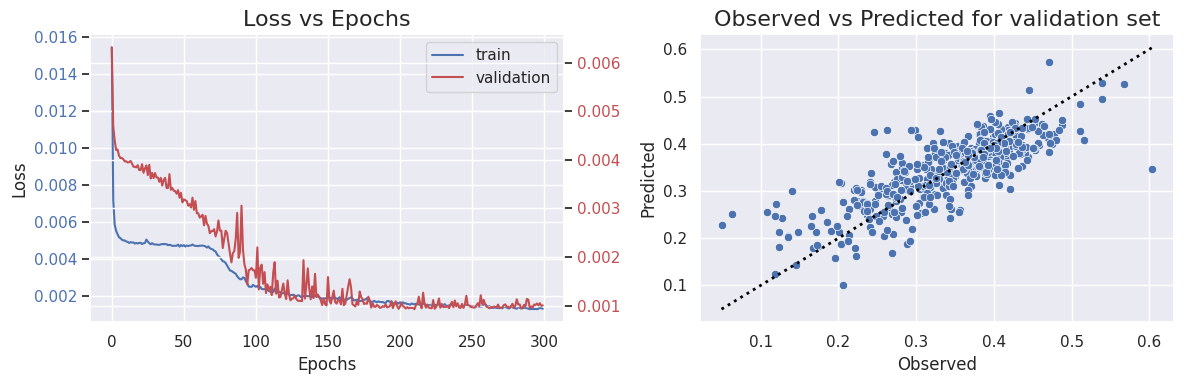

In [45]:
y_pred = lstmAttnModel.predict(X_val)

fig,(ax0,ax1) = plt.subplots(1,2,figsize=(12,4))
ax2 = ax0.twinx()

ln1 = sns.lineplot(x=history.epoch,y=history.history['loss'],color='b',ax=ax0)
ln2 = sns.lineplot(x=history.epoch,y=history.history['val_loss'],color='r',ax=ax2)

sns.scatterplot(x=y_val[:,-1,0],y=y_pred[:,-1,0],ax=ax1)
sns.lineplot(x=y_val[:,-1,0],y=y_val[:,-1,0],ls='dotted',lw=2,color='black',ax=ax1)
ax1.set(xlabel='Observed',ylabel='Predicted')
ax1.set_title('Observed vs Predicted for validation set',fontsize=16)

lns = ln1.lines+ln2.lines
labs = ['train', 'validation']
ax0.legend(lns, labs, loc=0)
ax0.tick_params(axis='y', labelcolor='b')
ax2.tick_params(axis='y', labelcolor='r')

ax0.set_title('Loss vs Epochs',fontsize=16)
ax0.set(xlabel='Epochs',ylabel='Loss')

plt.tight_layout()
plt.show()

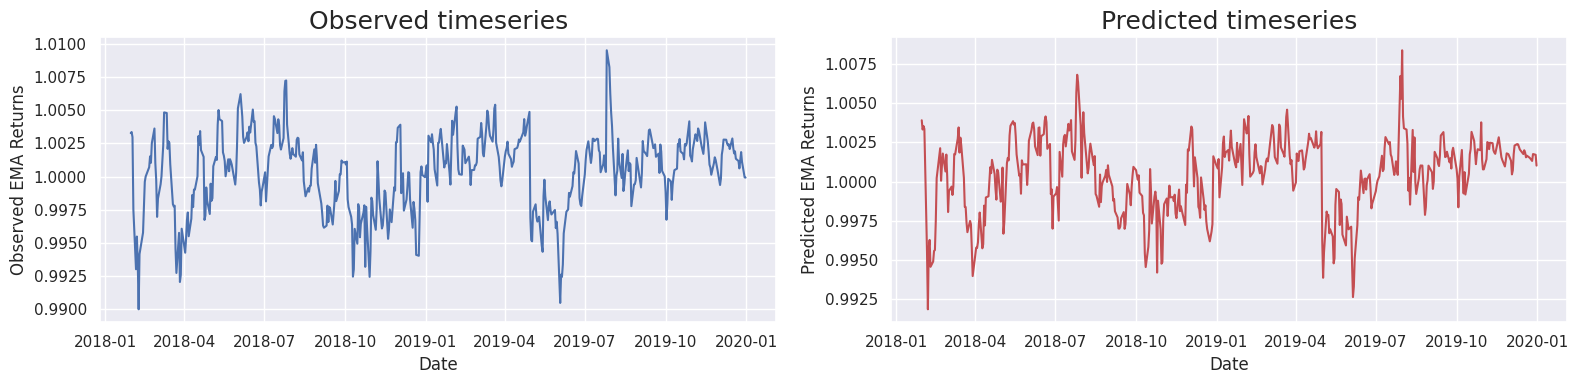

In [46]:
## transform back the timeseries
y_pred_actual = scaler.inverse_transform(y_pred[:,-1,0].reshape(-1,1)).flatten()

horizon_ahead = len(y_pred_actual)

fig,ax = plt.subplots(1,2,figsize=(16,4))

sns.lineplot(x=df_copy['Date'].iloc[-horizon_ahead:],y=df_copy['EMA Return'].iloc[-horizon_ahead:],ax=ax[0],color='b')
sns.lineplot(x=df_copy['Date'].iloc[-horizon_ahead:],y=y_pred_actual,ax=ax[1],color='r')

ax[0].set(ylabel='Observed EMA Returns')
ax[0].set_title('Observed timeseries',fontsize=18)
ax[1].set(ylabel='Predicted EMA Returns')
ax[1].set_title('Predicted timeseries',fontsize=18)

plt.tight_layout()
plt.show()

#### As before, the LSTM with Attention model predicts very well for the validation set and is able to capture the short term and as well as the long term fluctuations. However, we need to see how the model performs in future predictions.

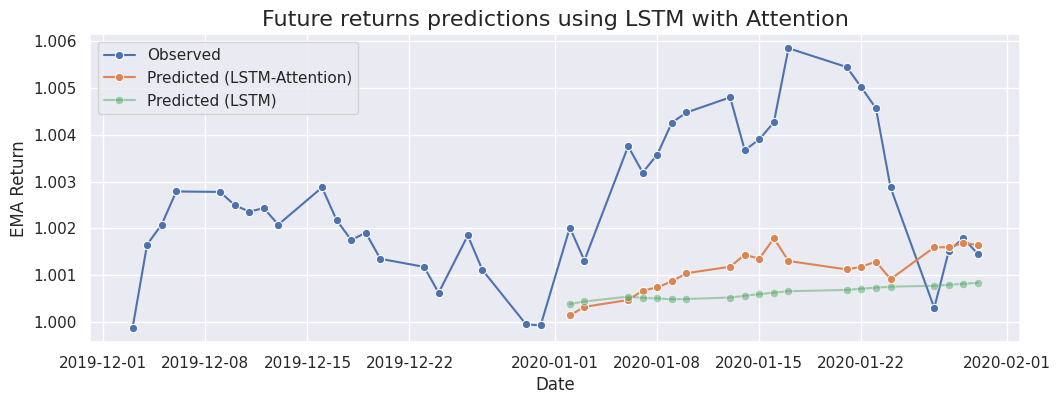

In [47]:
## Prediction for 20 future trading days
horizon_ahead = 20

predicted_prices_attn = predict_future_prices(lstmAttnModel,df_copy['EMA Return'],horizon_ahead)

fig,ax = plt.subplots(1,1,figsize=(12,4))

l1 = sns.lineplot(x=df_comp['Date'].iloc[:WINDOW_SIZE+horizon_ahead],y=df_comp['EMA Return'].iloc[:WINDOW_SIZE+horizon_ahead],marker='o',ax=ax)
l2 = sns.lineplot(x=df_comp['Date'].iloc[WINDOW_SIZE:WINDOW_SIZE+horizon_ahead],y=predicted_prices_attn,marker='o',ax=ax)
l3 = sns.lineplot(x=df_comp['Date'].iloc[WINDOW_SIZE:WINDOW_SIZE+horizon_ahead],y=predicted_prices,alpha=0.5,marker='o',ax=ax)

lns = l1.lines+l2.lines+l3.lines
labs = ['Observed', 'Predicted (LSTM-Attention)', 'Predicted (LSTM)']
ax.legend(lns, labs, loc=0)
ax.set_title('Future returns predictions using LSTM with Attention',fontsize=16)

plt.show()

#### The Attention mechanism improves the performance of the LSTM module, as can be seen from the plot. With Attention, the predictions are no longer constant and shows some fluctuations, both upward and downward.

In [48]:
loss_LSTM_Attn = mse_loss(actual_data,predicted_prices_attn)/actual_data.mean()
print(f'The error in the LSTM with Attention model : {loss_LSTM_Attn}')
print(f'The error in the LSTM model : {loss_LSTM}')
print(f'The error in the ARIMA model : {loss_ARIMA_return}')

The error in the LSTM with Attention model : 0.0027701385045605935
The error in the LSTM model : 0.003172198066813779
The error in the ARIMA model : 0.002962445841860188


#### However in terms of the relative error, we find that there is not much change. In fact all the 3 models so far produces very similar error. The LSTM with Attention, however, outperforms the sole LSTM module and can capture the small fluctuations to a better extent, thus reducing the mean-squared error.

#### In the next section we try another model popular with time series prediction, called Gated Recurrent Unit (GRU). With less parameters than LSTM, GRU is faster to train than LSTM.

### 5.5 GRU

In [49]:
## Necessary libraries
from tensorflow.keras.layers import GRU

In [53]:
## scaling

feature = 'EMA Return'

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_copy[feature].values.reshape(-1,1)).flatten()

split_index = int(nrows * train_split_ratio)
df_train_scaled = df_scaled[:split_index]
df_val_scaled = df_scaled[split_index:]

print(f"Train shape: {df_train_scaled.shape}")
print(f"Validation shape: {df_val_scaled.shape}")

## Creating training and validation sets

X_train, y_train = create_sequences_for_lstm(df_train_scaled, WINDOW_SIZE, horizon)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

X_val, y_val = create_sequences_for_lstm(df_val_scaled, WINDOW_SIZE, horizon)
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

Train shape: (2012,)
Validation shape: (504,)
X_train shape: (1992, 20, 1), y_train shape: (1992, 20, 1)
X_val shape: (484, 20, 1), y_val shape: (484, 20, 1)


In [54]:
# Model architecture

## Hyperparameters

UNITS = 32
DROPOUT_RATE = 0.2
HORIZON = 1

inputs = Input(shape=(WINDOW_SIZE,N_FEATURES),name='time_series_input')

## First GRU layer
x = GRU(UNITS,return_sequences=True)(inputs)

## Dropout layer
x = Dropout(DROPOUT_RATE)(x)

## Batch normalization
x = BatchNormalization(name='batch_norm')(x)

## second GRU layer
x = GRU(UNITS,return_sequences=True)(x)

## Final dense layer with sigmoid activation
outputs = TimeDistributed(Dense(units=HORIZON,activation='sigmoid'))(x)

gruModel = Model(inputs=inputs, outputs=outputs, name='lstm_forecaster')

# --- Compiling the Model ---

# learning schedule for the optimizer
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

# Adam is used as the optimizer
opt = keras.optimizers.Adam(learning_rate=lr_schedule)

gruModel.compile(optimizer=opt, loss='mse', metrics=[keras.metrics.MeanAbsoluteError()])

gruModel.summary()

Model: "lstm_forecaster"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_series_input (InputLayer)  │ (None, 20, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 20, 32)         │         3,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm (BatchNormalization) │ (None, 20, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 20, 32)         │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 20, 1)          │            33 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,857 (38.50 KB)

 Trainable params: 9,793 (38.25 KB)

 Non-trainable params: 64 (256.00 B)

In [55]:
start = time.time()

BATCH_SIZE = 200

early_stopping = EarlyStopping(monitor='val_loss', # Monitor validation loss
                               patience=10,        # Stop after 10 epochs with no improvement
                               restore_best_weights=True)

history = gruModel.fit(X_train, y_train,
                    epochs=400,
                    batch_size=BATCH_SIZE,
                    validation_split=0.2,
                    #callbacks=[early_stopping], # Early stopping callback
                    shuffle=True, # Shuffle training windows each epoch
                    verbose=0
                    )

end = time.time()

print(f"Training finished. Time elapsed: {(end-start)} seconds.")

Training finished. Time elapsed: 123.61474895477295 seconds.


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


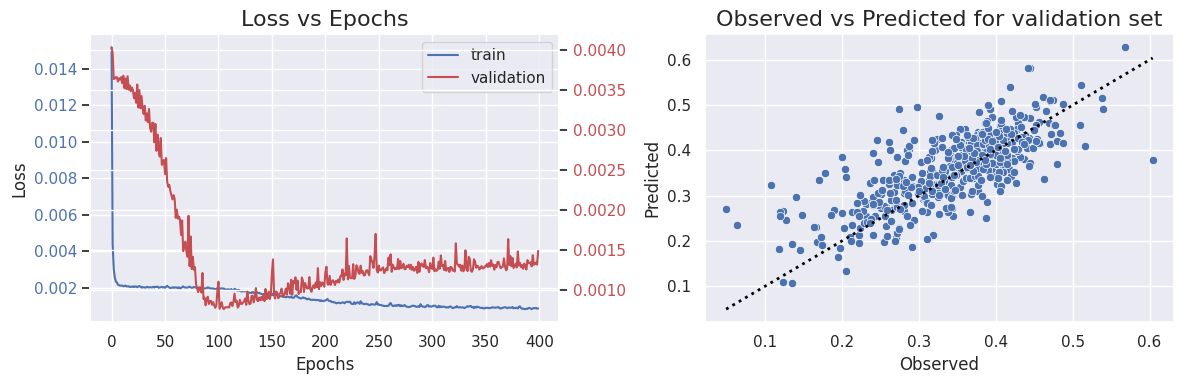

In [56]:
y_pred = gruModel.predict(X_val)

sns.set_theme(context='notebook',style='darkgrid')
fig,(ax0,ax1) = plt.subplots(1,2,figsize=(12,4))
ax2 = ax0.twinx()

ln1 = sns.lineplot(x=history.epoch,y=history.history['loss'],color='b',ax=ax0)
ln2 = sns.lineplot(x=history.epoch,y=history.history['val_loss'],color='r',ax=ax2)

sns.scatterplot(x=y_val[:,-1,0],y=y_pred[:,-1,0],ax=ax1)
sns.lineplot(x=y_val[:,-1,0],y=y_val[:,-1,0],ls='dotted',lw=2,color='black',ax=ax1)
ax1.set(xlabel='Observed',ylabel='Predicted')
ax1.set_title('Observed vs Predicted for validation set',fontsize=16)

lns = ln1.lines+ln2.lines
labs = ['train', 'validation']
ax0.legend(lns, labs, loc=0)
ax0.tick_params(axis='y', labelcolor='b')
ax2.tick_params(axis='y', labelcolor='r')

ax0.set_title('Loss vs Epochs',fontsize=16)
ax0.set(xlabel='Epochs',ylabel='Loss')

plt.tight_layout()
plt.show()

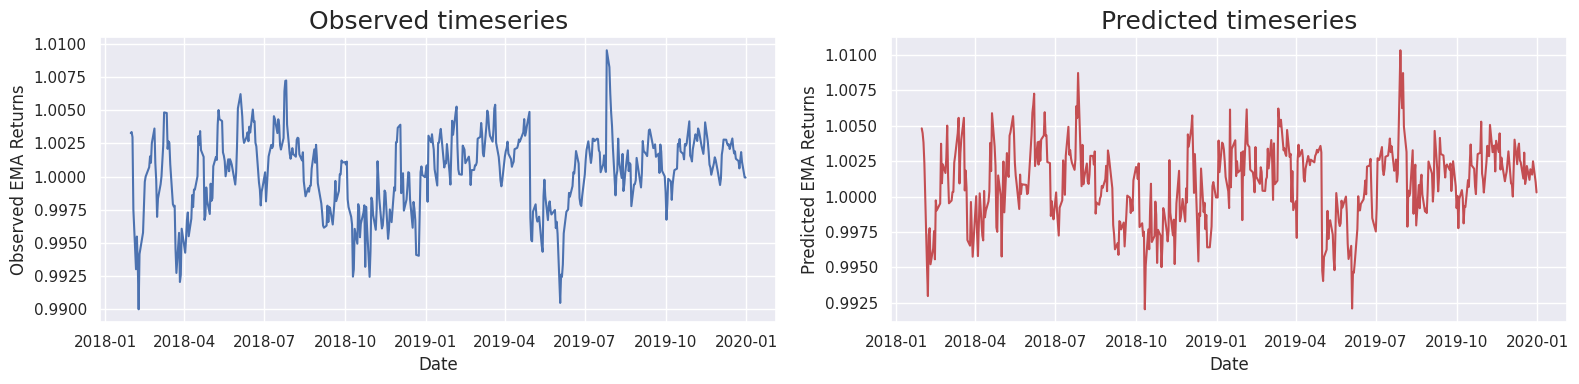

In [57]:
df_plot = df_era.copy()

y_pred_gru = scaler.inverse_transform(y_pred[:,-1,0].reshape(-1,1)).flatten() ## transform back the timeseries

horizon_ahead = len(y_pred_gru)

fig,ax = plt.subplots(1,2,figsize=(16,4))

sns.lineplot(x=df_plot['Date'].iloc[-horizon_ahead:],y=df_plot['EMA Return'].iloc[-horizon_ahead:],ax=ax[0],color='b')
sns.lineplot(x=df_plot['Date'].iloc[-horizon_ahead:],y=y_pred_gru,ax=ax[1],color='r')

ax[0].set(ylabel='Observed EMA Returns')
ax[0].set_title('Observed timeseries',fontsize=18)
ax[1].set(ylabel='Predicted EMA Returns')
ax[1].set_title('Predicted timeseries',fontsize=18)

plt.tight_layout()
plt.show()

#### Similar to the previous networks, GRU performs very well with the validation set.

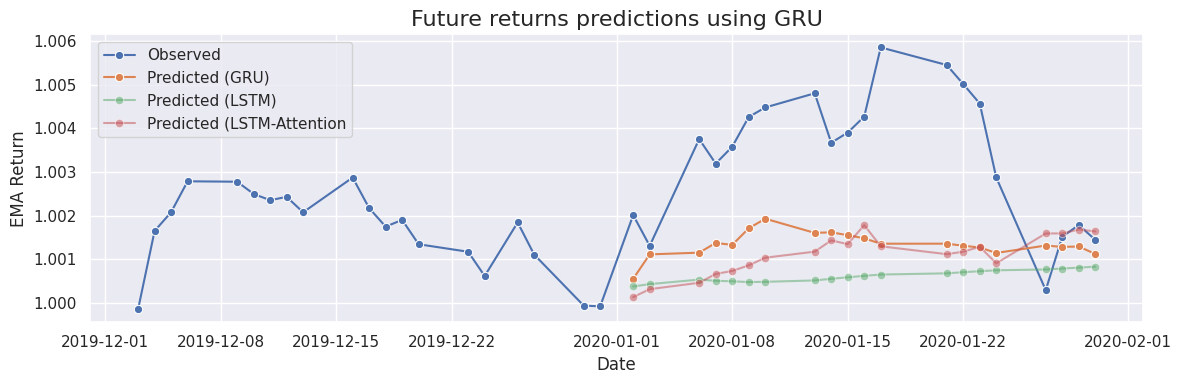

In [69]:
horizon_ahead = 20
predicted_prices_gru = predict_future_prices(gruModel,df_copy['EMA Return'],horizon_ahead)

fig,ax = plt.subplots(1,1,figsize=(12,4))

l1 = sns.lineplot(x=df_comp['Date'].iloc[:WINDOW_SIZE+horizon_ahead],y=df_comp['EMA Return'].iloc[:WINDOW_SIZE+horizon_ahead],marker='o',ax=ax)
l2 = sns.lineplot(x=df_comp['Date'].iloc[WINDOW_SIZE:WINDOW_SIZE+horizon_ahead],y=predicted_prices_gru,marker='o',ax=ax)
l3 = sns.lineplot(x=df_comp['Date'].iloc[WINDOW_SIZE:WINDOW_SIZE+horizon_ahead],y=predicted_prices,alpha=0.5,marker='o',ax=ax)
l4 = sns.lineplot(x=df_comp['Date'].iloc[WINDOW_SIZE:WINDOW_SIZE+horizon_ahead],y=predicted_prices_attn,alpha=0.5,marker='o',ax=ax)

lns = l1.lines+l2.lines+l3.lines+l4.lines
labs = ['Observed', 'Predicted (GRU)', 'Predicted (LSTM)', 'Predicted (LSTM-Attention']
ax.legend(lns, labs, loc=0)
ax.set_title('Future returns predictions using GRU',fontsize=16)

plt.tight_layout()
plt.show()

#### Compared to the basic LSTM module, GRU shows much better results in future predictions and performs quite similar to LSTM with Attention. One can notice that it predicts the short-term ups and downs which are quite consistent to the actual observed data.

In [66]:
loss_GRU = mse_loss(actual_data,predicted_prices_gru)/actual_data.mean()
print(f'The error in the GRU model : {loss_GRU}')
print(f'The error in the LSTM with Attention model : {loss_LSTM_Attn}')
print(f'The error in the LSTM model : {loss_LSTM}')
print(f'The error in the ARIMA model : {loss_ARIMA_return}')

The error in the GRU model : 0.002479994786194026
The error in the LSTM with Attention model : 0.0027701385045605935
The error in the LSTM model : 0.003172198066813779
The error in the ARIMA model : 0.002962445841860188


#### As expected from the plots, the GRU model outperforms all others and produces slightly less error than even the LSTM with Attention model. We consider ARIMA as the baseline and compare these two models against that.

In [65]:
improvement_factor_GRU = (loss_ARIMA_return - loss_GRU) / loss_ARIMA_return
improvement_factor_LSTM_Attn = (loss_ARIMA_return - loss_GRU) / loss_ARIMA_return

print(f'The LSTM with Attention model shows a {round(improvement_factor_LSTM_Attn*100,2)}% improvement over baseline ARIMA for the future predictions')
print(f'The GRU model shows a {round(improvement_factor_GRU*100,2)}% improvement over baseline ARIMA for the future predictions')

The LSTM with Attention model shows a 16.29% improvement over baseline ARIMA for the future predictions
The GRU model shows a 16.29% improvement over baseline ARIMA for the future predictions


#### In terms of future predictions, GRU and LSTM with Attention has been the best two models so far. Both show a $\sim 16 \%$ improvement over baseline ARIMA. In the next section, we shall look to improve GRU further by including Attention mechanism.

### 5.6 GRU with Attention

In [95]:
## scaling

feature = 'EMA Return'

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_copy[feature].values.reshape(-1,1)).flatten()

split_index = int(nrows * train_split_ratio)
df_train_scaled = df_scaled[:split_index]
df_val_scaled = df_scaled[split_index:]

print(f"Train shape: {df_train_scaled.shape}")
print(f"Validation shape: {df_val_scaled.shape}")

## Creating training and validation sets

X_train, y_train = create_sequences_for_lstm(df_train_scaled, WINDOW_SIZE, horizon)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

X_val, y_val = create_sequences_for_lstm(df_val_scaled, WINDOW_SIZE, horizon)
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

Train shape: (2012,)
Validation shape: (504,)
X_train shape: (1992, 20, 1), y_train shape: (1992, 20, 1)
X_val shape: (484, 20, 1), y_val shape: (484, 20, 1)


In [96]:
# Model architecture

inputs = Input(shape=(WINDOW_SIZE,N_FEATURES),name='time_series_input')

## query, key, value from the input data
q_input = TimeDistributed(Dense(units=N_FEATURES,name='query'))(inputs)
k_input = TimeDistributed(Dense(units=N_FEATURES,name='key'))(inputs)
v_input = TimeDistributed(Dense(units=N_FEATURES,name='value'))(inputs)

## Attention layer
x_attn = Attention(name='Attention_layer')([q_input,v_input,k_input])

## First GRU layer
x = GRU(UNITS,return_sequences=True)(x_attn)

## Dropout layer
x = Dropout(DROPOUT_RATE)(x)

## Batch normalization
x = BatchNormalization(name='batch_norm')(x)

## Second GRU layer
x = GRU(UNITS,return_sequences=True)(x)

## Final dense layer
outputs = TimeDistributed(Dense(units=HORIZON,activation='sigmoid'))(x)

gruAttnModel = Model(inputs=inputs, outputs=outputs, name='lstm_forecaster')

# --- Compiling the Model ---

# learning schedule for the optimizer
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

# Adam is used as the optimizer
opt = keras.optimizers.Adam(learning_rate=lr_schedule)

gruAttnModel.compile(optimizer=opt, loss='mse', metrics=[keras.metrics.MeanAbsoluteError()])

gruAttnModel.summary()

Model: "lstm_forecaster"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ time_series_input   │ (None, 20, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_17 │ (None, 20, 1)     │          2 │ time_series_inpu… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_19 │ (None, 20, 1)     │          2 │ time_series_inpu… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_18 │ (None, 20, 1)     │          2 │ time_series_inpu… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Attention_layer     │ (None, 20, 1)     │          0 │ time_distributed… │
│ (Attention)         │                   │            │ time_distributed… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_9 (GRU)         │ (None, 20, 32)    │      3,360 │ Attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 20, 32)    │          0 │ gru_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_norm          │ (None, 20, 32)    │        128 │ dropout_5[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_10 (GRU)        │ (None, 20, 32)    │      6,336 │ batch_norm[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_20 │ (None, 20, 1)     │         33 │ gru_10[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,863 (38.53 KB)

 Trainable params: 9,799 (38.28 KB)

 Non-trainable params: 64 (256.00 B)

In [97]:
start = time.time()

BATCH_SIZE = 200

early_stopping = EarlyStopping(monitor='val_loss', # Monitor validation loss
                               patience=10,        # Stop after 10 epochs with no improvement
                               restore_best_weights=True)

history = gruAttnModel.fit(X_train, y_train,
                    epochs=400,
                    batch_size=BATCH_SIZE,
                    validation_split=0.2,
                    #callbacks=[early_stopping], # Early stopping callback
                    shuffle=True, # Shuffle training windows each epoch
                    verbose=0
                    )

end = time.time()

print(f"Training finished. Time elapsed: {(end-start)} seconds.")

Training finished. Time elapsed: 134.48866963386536 seconds.


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step


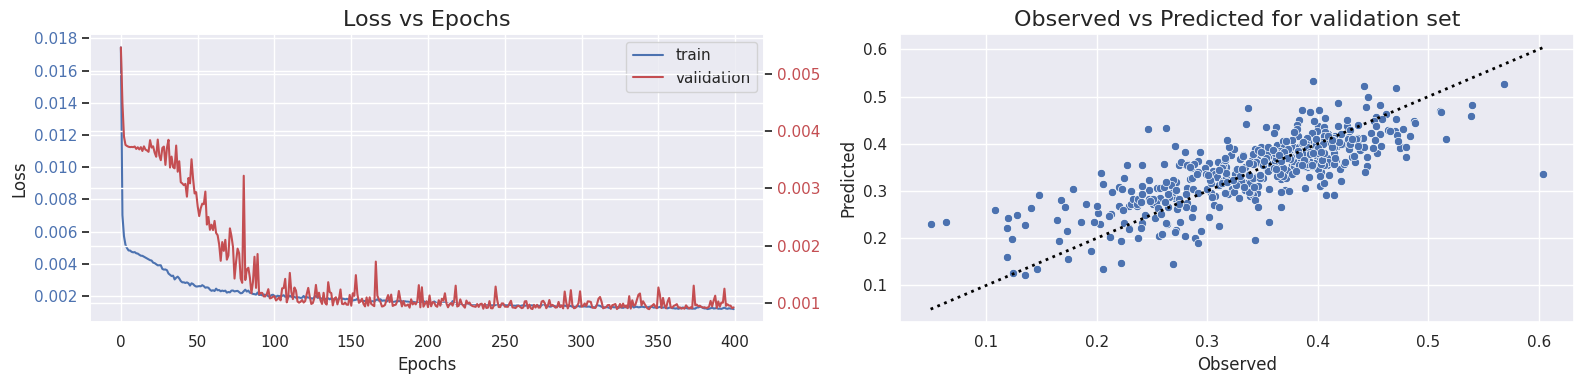

In [98]:
y_pred = gruAttnModel.predict(X_val)

sns.set_theme(context='notebook',style='darkgrid')
fig,(ax0,ax1) = plt.subplots(1,2,figsize=(16,4))
ax2 = ax0.twinx()

ln1 = sns.lineplot(x=history.epoch,y=history.history['loss'],color='b',ax=ax0)
ln2 = sns.lineplot(x=history.epoch,y=history.history['val_loss'],color='r',ax=ax2)

sns.scatterplot(x=y_val[:,-1,0],y=y_pred[:,-1,0],ax=ax1)
sns.lineplot(x=y_val[:,-1,0],y=y_val[:,-1,0],ls='dotted',lw=2,color='black',ax=ax1)
ax1.set(xlabel='Observed',ylabel='Predicted')
ax1.set_title('Observed vs Predicted for validation set',fontsize=16)

lns = ln1.lines+ln2.lines
labs = ['train', 'validation']
ax0.legend(lns, labs, loc=0)
ax0.tick_params(axis='y', labelcolor='b')
ax2.tick_params(axis='y', labelcolor='r')

ax0.set_title('Loss vs Epochs',fontsize=16)
ax0.set(xlabel='Epochs',ylabel='Loss')

plt.tight_layout()
plt.show()

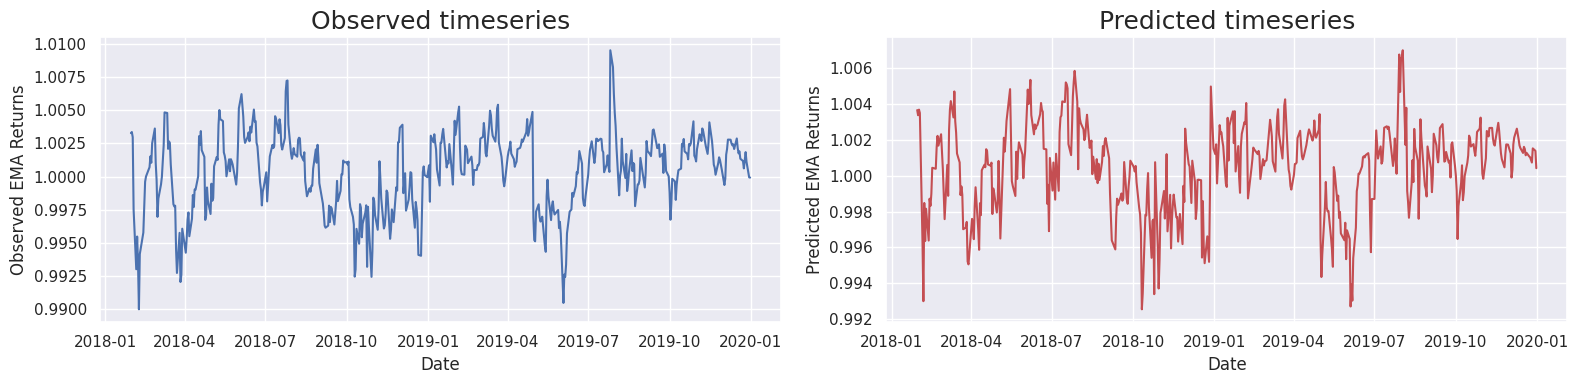

In [99]:
df_plot = df_era.copy()

y_pred_gruAttn = scaler.inverse_transform(y_pred[:,-1,0].reshape(-1,1)).flatten() ## transform back the timeseries

horizon_ahead = len(y_pred_gruAttn)

fig,ax = plt.subplots(1,2,figsize=(16,4))

sns.lineplot(x=df_plot['Date'].iloc[-horizon_ahead:],y=df_plot['EMA Return'].iloc[-horizon_ahead:],ax=ax[0],color='b')
sns.lineplot(x=df_plot['Date'].iloc[-horizon_ahead:],y=y_pred_gruAttn,ax=ax[1],color='r')

ax[0].set(ylabel='Observed EMA Returns')
ax[0].set_title('Observed timeseries',fontsize=18)
ax[1].set(ylabel='Predicted EMA Returns')
ax[1].set_title('Predicted timeseries',fontsize=18)

plt.tight_layout()
plt.show()

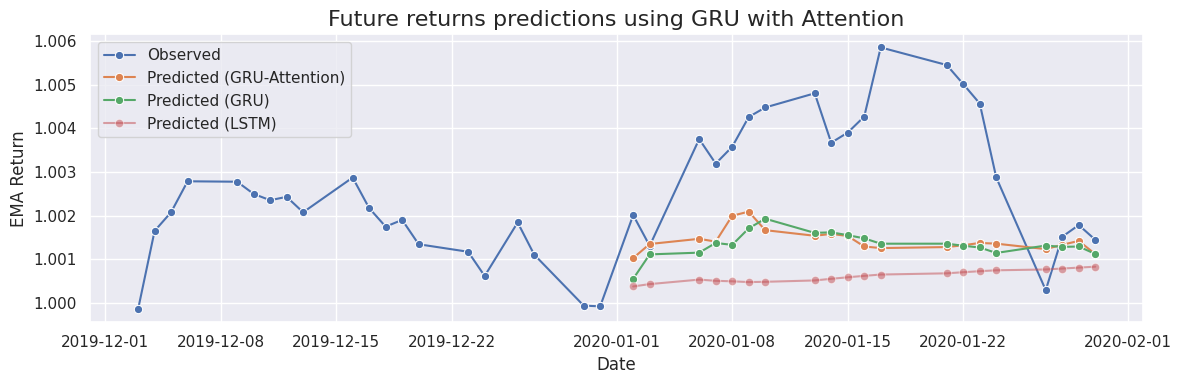

In [101]:
horizon_ahead = 20
predicted_prices_gruAttn = predict_future_prices(gruAttnModel,df_copy['EMA Return'],horizon_ahead)

fig,ax = plt.subplots(1,1,figsize=(12,4))

l1 = sns.lineplot(x=df_comp['Date'].iloc[:WINDOW_SIZE+horizon_ahead],y=df_comp['EMA Return'].iloc[:WINDOW_SIZE+horizon_ahead],marker='o',ax=ax)
l2 = sns.lineplot(x=df_comp['Date'].iloc[WINDOW_SIZE:WINDOW_SIZE+horizon_ahead],y=predicted_prices_gruAttn,marker='o',ax=ax)
l3 = sns.lineplot(x=df_comp['Date'].iloc[WINDOW_SIZE:WINDOW_SIZE+horizon_ahead],y=predicted_prices_gru,marker='o',ax=ax)
l4 = sns.lineplot(x=df_comp['Date'].iloc[WINDOW_SIZE:WINDOW_SIZE+horizon_ahead],y=predicted_prices,alpha=0.5,marker='o',ax=ax)

lns = l1.lines+l2.lines+l3.lines+l4.lines
labs = ['Observed', 'Predicted (GRU-Attention)', 'Predicted (GRU)', 'Predicted (LSTM)']
ax.legend(lns, labs, loc=0)
ax.set_title('Future returns predictions using GRU with Attention',fontsize=16)

plt.tight_layout()
plt.show()

#### The GRU with Attention performs very similar to the sole GRU model. Therefore, we do not expect much improvement in terms of error.

In [102]:
loss_GRUAttn = mse_loss(actual_data,predicted_prices_gruAttn)/actual_data.mean()

print(f'The error in the GRU with Attention model : {loss_GRUAttn}')
print(f'The error in the GRU model : {loss_GRU}')
print(f'The error in the LSTM with Attention model : {loss_LSTM_Attn}')
print(f'The error in the LSTM model : {loss_LSTM}')
print(f'The error in the ARIMA model : {loss_ARIMA_return}')

The error in the GRU with Attention model : 0.0024371087902552496
The error in the GRU model : 0.002479994786194026
The error in the LSTM with Attention model : 0.0027701385045605935
The error in the LSTM model : 0.003172198066813779
The error in the ARIMA model : 0.002962445841860188


#### The GRU with Attention model outperforms the GRU by a very small margin and hence so far it is the better model.

In [103]:
improvement_factor_GRUAttn = (loss_ARIMA_return - loss_GRUAttn) / loss_ARIMA_return

print(f'The LSTM with Attention model shows a {round(improvement_factor_LSTM_Attn*100,2)}% improvement over baseline ARIMA for the future predictions')
print(f'The GRU model shows a {round(improvement_factor_GRU*100,2)}% improvement over baseline ARIMA for the future predictions')
print(f'The GRU with Attention model shows a {round(improvement_factor_GRUAttn*100,2)}% improvement over baseline ARIMA for the future predictions')

The LSTM with Attention model shows a 16.29% improvement over baseline ARIMA for the future predictions
The GRU model shows a 16.29% improvement over baseline ARIMA for the future predictions
The GRU with Attention model shows a 17.73% improvement over baseline ARIMA for the future predictions


#### The predictions made by GRU with Attention is better than the rest, by just $2 \%$. All the three model captures the small-time upward and downward movements to quite a good degree, with almost exact overlap at later points. To summarize, the LSTM with Attention and GRU shows $\sim 16 \%$ improvement over baseline and GRU with Attention shows a $\sim 18 \%$ improvement. Hence, it is the best performing model.

# ----- Unfinished analysis -----

## Kolgomorov-Arnold Network (KAN) model

In [ ]:
feature = 'EMA'
scaler = MinMaxScaler()
df_kan_scaled = scaler.fit_transform(df_copy[feature].values.reshape(-1,1)).flatten()
df_kan_scaled.shape

In [ ]:
window_size = 20
horizon = 1
train_split_ratio = 0.8

X, y = [], []
n_steps = len(df_kan_scaled)
for j in range(n_steps - window_size):
    window = df_kan_scaled[j:(j + window_size)]
    target = df_kan_scaled[(j + window_size):(j + window_size + horizon)]
    X.append(window)
    y.append(target)

X = torch.tensor(X,dtype=torch.float32)
y = torch.tensor(y,dtype=torch.float32).flatten()

ncols = X.shape[0]
split_index = int(ncols * train_split_ratio)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index].reshape(-1,1), y[split_index:].reshape(-1,1)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_test.shape}, y_val shape: {y_test.shape}")

### Simplistic KAN module

In [ ]:
class KolmogorovArnoldNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.decomposition = nn.Linear(input_dim, hidden_dim)
        self.aggregation = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h = torch.tanh(self.decomposition(x))
        return self.aggregation(h)


In [ ]:
model = KolmogorovArnoldNetwork(window_size, 20, 1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
start = time.time()

loss_data = []

for epoch in range(100):
    model.train()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss_data.append(loss.detach())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #print(f'epoch {epoch}: finished')

end = time.time()

print(f"time elapsed: {end-start} seconds.")

In [ ]:
plt.plot(range(100),loss_data)

In [ ]:
model.eval()
with torch.no_grad():
    predictions_kan = model(X_test).numpy()
    predictions_kan = scaler.inverse_transform(predictions_kan)
    y_test_actual = scaler.inverse_transform(y_test)

In [ ]:
y_test.shape

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(12,4))

sns.lineplot(x=np.arange(len(y_test_actual)),y=y_test_actual.flatten(),label='actual',ax=ax)
sns.lineplot(x=np.arange(len(y_test_actual)),y=predictions_kan.flatten(),c='r',label='predicted',ax=ax)

#sns.scatterplot(x=y_test_actual.flatten(),y=predictions_kan.flatten(),s=6,c='r',ax=ax1)

plt.show()

In [ ]:
horizon_ahead = len(y_val) - window_size
last_known_scaled = df_kan_scaled[-horizon_ahead-window_size:-horizon_ahead]
forecast_scaled = []

model.eval()
with torch.no_grad():
    for _ in range(horizon_ahead):
        input_tensor = torch.tensor(last_known_scaled,dtype=torch.float32)
        pred = model(input_tensor).item()
        forecast_scaled.append(pred)
        last_known_scaled = np.append(last_known_scaled[1:], pred)

forecast_unscaled = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1)).flatten()


In [ ]:
df_kan_actual = scaler.inverse_transform(df_kan_scaled.reshape(-1,1)).flatten()

#plot_data = list(df_kan_actual)

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(12,3))

sns.lineplot(x=df_copy['Date'],y=df_copy['EMA'],ax=ax)
sns.lineplot(x=df_copy['Date'].iloc[-horizon_ahead:],y=forecast_unscaled,ax=ax)

plt.show()

### Pykan module

In [ ]:
kanmodel = KAN(width=[3,5,5,3,1], grid=3, k=3, seed=0)

In [ ]:
dataset = {}

dataset['train_input'] = X_train
dataset['test_input'] = X_test
dataset['train_label'] = y_train
dataset['test_label'] = y_test

X = dataset['train_input']
y = dataset['train_label']

In [ ]:
kanmodel(dataset['train_input']);
kanmodel.plot()

In [ ]:
def train_acc():
    loss = nn.MSELoss()
    return loss(kanmodel(dataset['train_input']),dataset['train_label'])

def test_acc():
    loss = nn.MSELoss()
    return loss(kanmodel(dataset['test_input']), dataset['test_label'])

In [ ]:
kanmodel.fit(dataset, opt='LBFGS', steps=20, metrics=(train_acc, test_acc), loss_fn=nn.MSELoss());

In [ ]:
kanmodel = kanmodel.prune()
kanmodel.plot()

In [ ]:
kanmodel = kanmodel.prune(node_th = 1e-1)

In [ ]:
kanmodel.fit(dataset, opt='LBFGS', steps=50, metrics=(train_acc, test_acc), loss_fn=nn.MSELoss());

In [ ]:
kanmodel = kanmodel.prune(node_th=1e-1)
kanmodel(dataset['train_input'])
kanmodel.plot()

In [ ]:
y_pred = kanmodel.forward(dataset['test_input']).detach().numpy().flatten()
y_pred.shape,dataset['test_label'].shape

In [ ]:
y_pred = scaler.inverse_transform(y_pred.reshape(-1,1)).flatten()
y_actual = scaler.inverse_transform(dataset['test_label'].reshape(-1,1)).flatten()

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(12,3))

sns.lineplot(x=np.arange(len(y_pred)),y=y_actual,ax=ax[0])
sns.lineplot(x=np.arange(len(y_pred)),y=y_pred,c='r',ax=ax[1])

plt.show()

## Old analysis

In [ ]:
## Pre Crash era

i1,i2 = 100,701

df['Date'] = pd.to_datetime(df['Date'])

df['SMA(20)'] = df['Open'].rolling(window=20).mean()
df['EMA'] = df['Open'].ewm(span=20,adjust=True).mean()
df['CMA'] = df['Open'].expanding(min_periods=20).mean()

plt.figure(figsize=(9,4))
plt.plot(df['Date'][i1:i2],df.iloc[i1:i2,1])
plt.plot(df['Date'][i1:i2],df['SMA(20)'][i1:i2])
plt.plot(df['Date'][i1:i2],df['EMA'][i1:i2])
plt.plot(df['Date'][i1:i2],df['CMA'][i1:i2])

deltaT = (df['Date'][i2]-df['Date'][i1]).total_seconds()
deltaP = (df['Open'][i2]-df['Open'][i1])
slp = deltaP/deltaT
intrcpt = df['Open'][i1]

plt.gca().plot(df['Date'][i1:i2],intrcpt + slp*(df['Date'][i1:i2] - df['Date'][i1]).dt.total_seconds(),ls='dashed',lw=2)

plt.show()

In [ ]:
meanDrift = (df['Log Gain'][i2] - df['Log Gain'][i1])/(deltaT/(3600*24)) ## unit of time 1 day
meanVolatility = np.sqrt(df['Log Gain'][i1:i2].var())

meanDrift,meanVolatility,deltaT

In [ ]:
dataSMA = df['SMA(20)'][i1:i2].dropna()
id1,id2 = pd.Index(df['SMA(20)']).get_loc(dataSMA.values[0]), pd.Index(df['SMA(20)']).get_loc(dataSMA.values[-1])
deltaT = (df['Date'][id2]-df['Date'][id1]).total_seconds()
deltaP = (dataSMA.values[-1]-dataSMA.values[0])
slp = deltaP/(deltaT/(3600*24))
# slp
deltaT

In [ ]:
df.head()

In [ ]:
def create_noise_array(corrCoeff,N):
    means = [0,0]
    covs = np.ones((2,2))*corrCoeff
    np.fill_diagonal(covs,1)

    return np.random.multivariate_normal(means,covs,size=N).T

def update_stock_price(S0,v0,dT,r,theta,omega,zeta,A,B): ## GARCH model
    v = v0 + theta*(omega - v0)*dT + zeta*v0*B*np.sqrt(dT)
    s = S0 + (r - 0.5*v)*S0*dT + np.sqrt(v*dT)*S0*A
    return s,v

def create_paths(T,rho,S0,V0,dT,r,theta,omega,zeta):
    tlocal = 0
    idx = 1
    NT = int(T.array[-1]/dT)+1
    Sarr,Varr = [S0],[V0]
    s0,v0 = S0,V0
    # Sarr[0],Varr[0] = s0,v0
    Noise = create_noise_array(rho,NT)
    for i in range(1,NT):
        # print(f"s0 = {s0},v0 = {v0}")
        s,v = update_stock_price(s0,v0,dT,r,theta,omega,zeta,Noise[0,i-1],Noise[1,i-1])
        s0,v0 = s,v
        tlocal += dT
        # print(round(tlocal,2))
        # if (round(tlocal,1)==T.array[idx]):
            # print(f"idx is {idx}")
        Sarr.append(s),Varr.append(v)
            # idx += 1
        
        # print(f"s = {s},v = {v}")

    return Sarr,Varr

In [ ]:
T = (df['Date'][i1:i2]-df['Date'][i1]).dt.total_seconds()
T = T[:2]
# T = T.array[::2]
dT = 0.1
S0,V0 = df['Open'][0],meanVolatility
rho = 0.7
r,theta,omega,zeta = 0.03,0.05,0.06,0.05

Sarr,Varr = create_paths(T,rho,S0,V0,dT,r,theta,omega,zeta)
# T.array[1]

In [ ]:
dfS = pd.DataFrame(Sarr,columns=['S'])
dfS['V'] = Varr
dfS['Log Gain'] = dfS['S'].apply(lambda x : np.log(x)).diff()
plt.plot(dfS.iloc[i1:601,1])
# dfS.loc[(dfS['S']<=0)].any()

In [ ]:
ntest = create_noise_array(0.2,10000)
a,b,c = plt.hist(ntest[0,:],bins=100)

In [ ]:
a1 = create_noise_array(0,1000)
at1 = a1[0,:].T
at2 = a1[1,:].T

In [ ]:
np.dot(at1,at2),np.sum(at1**2)

In [ ]:
horizon_ahead = len(y_val[:,-1,0]) - WINDOW_SIZE
last_known_scaled = np.array(df_val_scaled[-horizon_ahead-WINDOW_SIZE:-horizon_ahead])
forecast_scaled = []

for _ in range(horizon_ahead):
    pred = LSTMmodel(last_known_scaled.reshape(-1,WINDOW_SIZE,1)).numpy()[:,-1,0]
    forecast_scaled.append(pred)
    last_known_scaled = np.append(last_known_scaled[1:], pred)

forecast_unscaled = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1)).flatten()
forecast_EMA = forecast_unscaled * df_copy['EMA'].shift(1).iloc[-horizon_ahead:]

### Additional analysis

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(8,4))

sns.lineplot(data=df,x='Date',y='Log Return',ax=ax)

meanGain,stdGain = df['Log Return'].mean(),np.sqrt(df['Log Return'].var())
seMeanGain = stdGain/np.sqrt(df.shape[0])
seForecastGain = np.sqrt(stdGain**2 + seMeanGain**2)

gP95,gM95 = meanGain + 2.093*seForecastGain, meanGain - 2.093*seForecastGain
gP50,gM50 = meanGain + 0.688*seForecastGain, meanGain - 0.688*seForecastGain

ax.axhline(gP95,color='red',ls='dashed',lw=2,label='95% confidence lines')
ax.axhline(gM95,color='red',ls='dashed',lw=2)

ax.set(title='Log Return of the stock')

plt.legend()

plt.show()

#### Too many observations outside 95% confidence interval, which are calculated under the assumption that the gains are independent and are distributed normally. Therefore, there are two possibilities. The most logical guess would be that the gains are not independent (volatility clustering).

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(8,4))

sns.histplot(data=df,x='Log Return',kde=True,bins=100,ax=ax)

ax.set(title='Distribution of log return of the stock')

plt.show()